# Imports

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)#set  random seed for reproducability
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from keras.models import Sequential
from keras.layers import Dense
import gmaps

# Load Data and Merge

In [2]:
arrest_data = pd.read_csv("arrests_w_census_loc.csv")
arrest_data.PERP_RACE[arrest_data.PERP_RACE.str.contains("WHITE")]=0
arrest_data.PERP_RACE[arrest_data.PERP_RACE != 0]=1
arrest_data = arrest_data.groupby(["PERP_RACE","BlockLocation"]).size().reset_index(name='counts')
blockLocation = arrest_data["BlockLocation"]
blockLat = [float(re.findall(r'[-\d\.]+', bl)[0]) for bl in blockLocation]
blockLon = [float(re.findall(r'[-\d\.]+', bl)[1]) for bl in blockLocation]
arrest_data["blockLat"]=blockLat
arrest_data["blockLon"]=blockLon
arrest_data = arrest_data.drop("BlockLocation", axis=1)
arrest_data = arrest_data.rename(columns={"counts": "Num_Arrests", "PERP_RACE": "Race"})
block_data = pd.read_csv("census_block_loc.csv")
block_data = pd.merge(left=arrest_data, right=block_data,
                      left_on=["blockLat","blockLon"], right_on=["Latitude","Longitude"])
census_data = pd.read_csv("nyc_census_tracts.csv")
tracts = block_data["BlockCode"]
tracts = [int(str(tract)[:-4]) for tract in tracts]
block_data["tracts"]=tracts
block_data = block_data.drop(columns=["Latitude","Longitude","BlockCode","County","blockLat","blockLon"])
data = pd.merge(left=block_data, right=census_data, left_on="tracts", right_on="CensusTract")
data = data.drop("tracts", axis=1)
data = data.drop("State", axis=1)

/home/erik7brown/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/erik7brown/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# Remove Outlier Locations

There are 11341 Samples Before Outlier Removal


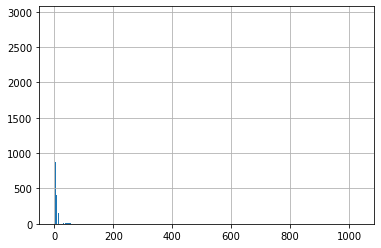

There are 11021 Samples After Outlier Removal


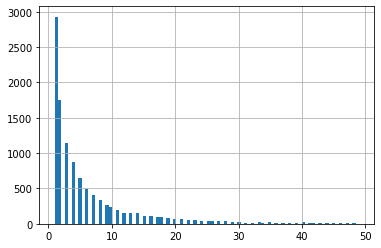

97.1783793316286% of Samples were Kept


In [3]:
data["Num_Arrests"].hist(bins='auto')
data_size=data.shape[0]
print("There are",data_size,"Samples Before Outlier Removal")
plt.show()
data = data[data["Num_Arrests"]<50]
new_size=data.shape[0]
print("There are",new_size,"Samples After Outlier Removal")
data["Num_Arrests"].hist(bins='auto')
plt.show()
print(100*new_size/data_size,"% of Samples were Kept",sep="")

# Create Data Aggregates by County

In [4]:
def agg_all(data):
    new_data = {}
    for colname in ['Num_Arrests','TotalPop','Men','Women','Citizen','Income','IncomeErr', 'Employed']:
        new_data[colname]=data[colname].sum()
    for colname in ['Hispanic', 'White', 'Black', 'Native', 'Asian','IncomePerCap','IncomePerCapErr','Poverty', 'ChildPoverty', 'Professional', 'Service', 'Office',
            'Construction', 'Production', 'Drive', 'Carpool', 'Transit', 'Walk','OtherTransp', 'WorkAtHome',
           'MeanCommute','PrivateWork','PublicWork','SelfEmployed','FamilyWork','Unemployment']:
        ratio = data[colname]*data['TotalPop']
        new_data[colname]=(ratio.sum()/100)/data.size
    return pd.Series(new_data)

agg_data = data.groupby(['County','Race']).apply(agg_all)

# Attatch Aggregate to Data

In [5]:
agg_data["arrest_ratio"]=agg_data["Num_Arrests"]/agg_data["TotalPop"]
arrest_ratio = list(agg_data["arrest_ratio"])
county = list(agg_data.index.get_level_values(0))
race = list(agg_data.index.get_level_values(1))
agg_data = pd.DataFrame(arrest_ratio, columns=["arrest_ratio"])
agg_data["County"]=county
agg_data["Race"]=race
data = pd.merge(data, agg_data, on=["County","Race"])
data["County_Num_Arrests"]=data["arrest_ratio"]*data["TotalPop"]
data = data.drop("arrest_ratio", axis=1)

# Apply Z Scaling to Continuous Features

In [6]:
num_cols = ['TotalPop','Men','Women','Hispanic','White','Black','Native','Asian','Citizen','Income','IncomeErr','IncomePerCap','IncomePerCapErr','Poverty','ChildPoverty','Professional','Service','Office','Construction','Production','Drive','Carpool','Transit','Walk','OtherTransp','WorkAtHome','MeanCommute','Employed','PrivateWork','PublicWork','SelfEmployed','FamilyWork','Unemployment']
X = data[num_cols].values
data.drop(columns=num_cols)
scaler = StandardScaler()
X = scaler.fit_transform(X)
num_data = pd.DataFrame(X, columns=num_cols)
data[num_cols]=num_data
data = data.dropna()

# Split Data by Race and Into Train/Test Datasets

In [7]:
cols = data.shape[1]
data_white = data[data["Race"]==0].drop("Race", axis=1)
data_non_white=data[data["Race"]==1].drop("Race", axis=1)
data_white_train = data_white.sample(frac=0.8,random_state=101)
data_white_test  = data_white.drop(data_white_train.index)
data_non_white_train = data_non_white.sample(frac=0.8,random_state=101)
data_non_white_test  = data_non_white.drop(data_non_white_train.index)
Xw = data_white_train.iloc[:,1:cols]
yw = data_white_train.iloc[:,0]
Xnw = data_non_white_train.iloc[:,1:cols]
ynw = data_non_white_train.iloc[:,0]
Xwt = data_white_test.iloc[:,1:cols]
ywt = data_white_test.iloc[:,0]
Xnwt = data_non_white_test.iloc[:,1:cols]
ynwt = data_non_white_test.iloc[:,0]

# Encode Categorical Features as Numerical Values

In [8]:
cat_cols = ['County','Borough']
encoder = LabelEncoder()
for var in cat_cols:
    Xw[var] = encoder.fit_transform(Xw[var])
    Xnw[var] = encoder.fit_transform(Xnw[var])
    Xwt[var] = encoder.fit_transform(Xwt[var])
    Xnwt[var] = encoder.fit_transform(Xnwt[var])

# Initial Test of Nonlinear Kernels

In [9]:
rbfw = SVR(gamma='scale',kernel='rbf')
cv = cross_val_score(rbfw, Xw, yw, cv=50, scoring="neg_mean_squared_error")
print("The average MSE for White RBF is",-sum(cv)/len(cv))

rbfnw = SVR(gamma='scale',kernel='rbf')
cv = cross_val_score(rbfnw, Xnw, ynw, cv=50, scoring="neg_mean_squared_error")
print("The average MSE for Non-White RBF is",-sum(cv)/len(cv))

polyw = SVR(gamma='scale',kernel='poly')
cv = cross_val_score(polyw, Xw, yw, cv=50, scoring="neg_mean_squared_error")
print("The average MSE for White Polynomial is",-sum(cv)/len(cv))

polynw = SVR(gamma='scale',kernel='poly')
cv = cross_val_score(polynw, Xnw, ynw, cv=50, scoring="neg_mean_squared_error")
print("The average MSE for Non-White Polynomial is",-sum(cv)/len(cv))

The average MSE for White RBF is 46.179159341322745
The average MSE for Non-White RBF is 85.44340974736384
The average MSE for White Polynomial is 46.17123584555261
The average MSE for Non-White Polynomial is 85.40059807430639


# Random Search to Tune Hyperparameters

In [10]:
params = {"C":[0.1,0.5,1,5,10,50,100,500,1000],"epsilon":uniform(1,3),"kernel":["poly","rbf"]}

rscv = RandomizedSearchCV(SVR(gamma="scale"),params,cv=50,iid=False)
rscv.fit(Xw,yw)
print("optimal white C", rscv.best_estimator_.get_params()["C"])
print("optimal white epsilon", rscv.best_estimator_.get_params()["epsilon"])
print("optimal white kernel", rscv.best_estimator_.get_params()["kernel"])

rscv2 = RandomizedSearchCV(SVR(gamma="scale"),params,cv=50,iid=False)
rscv2.fit(Xnw,ynw)
print("optimal non-white C", rscv2.best_estimator_.get_params()["C"])
print("optimal non-white epsilon", rscv2.best_estimator_.get_params()["epsilon"])
print("optimal non-white kernel", rscv2.best_estimator_.get_params()["kernel"])


optimal white C 1000
optimal white epsilon 3.4540442977674792
optimal white kernel poly
optimal non-white C 1000
optimal non-white epsilon 2.6439156497442617
optimal non-white kernel poly


# Run Test Data

In [11]:
Final_model = SVR(kernel='poly', C=1000, gamma="scale", epsilon=3)
Final_model.fit(Xw, yw)
test_predicted = Final_model.predict(Xwt)
mse = mean_squared_error(ywt, test_predicted)
print("Test MSE for White: ",mse)
mae = mean_absolute_error(ywt, test_predicted)
print("Test MAE for White: ",mae)
Final_model.fit(Xnw, ynw)
test_predicted_2 = Final_model.predict(Xnwt)
mse = mean_squared_error(ynwt, test_predicted_2)
print("Test MSE for Non-White: ",mse)
mae = mean_absolute_error(ynwt, test_predicted_2)
print("Test MAE for Non-White: ",mae)

Test MSE for White:  41.8569274422559
Test MAE for White:  3.527750353290907
Test MSE for Non-White:  97.31817511189523
Test MAE for Non-White:  5.864886060611893


# Try Random Forrest

In [12]:
model = RandomForestRegressor()
model.fit(Xw, yw)
cv = cross_val_score(model, Xw, yw, cv=50, scoring="neg_mean_squared_error")
print("The average MSE for White is",-sum(cv)/len(cv))
model.fit(Xnw, ynw)
cv = cross_val_score(model, Xnw, ynw, cv=50, scoring="neg_mean_squared_error")
print("The average MSE for Non-White is",-sum(cv)/len(cv))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


The average MSE for White is 36.96929308092166
The average MSE for Non-White is 58.75680945902769


# Tune Random Forrest Hyperparameters

In [13]:
params = {"min_samples_split":[2,5,10,20,25,30,35,40,45,50], "max_features":[5,10,15,20,25,30,35]}

rscv = RandomizedSearchCV(RandomForestRegressor(n_estimators=500),params,cv=50,iid=False)
rscv.fit(Xw,yw)
print("optimal white min_samples_split", rscv.best_estimator_.get_params()["min_samples_split"])
print("optimal white max_features", rscv.best_estimator_.get_params()["max_features"])

rscv2 = RandomizedSearchCV(RandomForestRegressor(n_estimators=500),params,cv=50,iid=False)
rscv2.fit(Xnw,ynw)
print("optimal non-white min_samples_split", rscv2.best_estimator_.get_params()["min_samples_split"])
print("optimal non-white max_features", rscv2.best_estimator_.get_params()["max_features"])

optimal white min_samples_split 35
optimal white max_features 30
optimal non-white min_samples_split 30
optimal non-white max_features 15


# Predict Test Data From Best Model

In [14]:
Final_model = RandomForestRegressor(n_estimators=500, min_samples_split=32, max_features=20)
Final_model.fit(Xw, yw)
test_predicted = Final_model.predict(Xwt)
mse = mean_squared_error(ywt, test_predicted)
print("Test MSE for White: ",mse)
mae = mean_absolute_error(ywt, test_predicted)
print("Test MAE for White: ",mae)
Final_model.fit(Xnw, ynw)
test_predicted_2 = Final_model.predict(Xnwt)
mse = mean_squared_error(ynwt, test_predicted_2)
print("Test MSE for Non-White: ",mse)
mae = mean_absolute_error(ynwt, test_predicted_2)
print("Test MAE for Non-White: ",mae)

Test MSE for White:  30.34324297021098
Test MAE for White:  3.2946318028531985
Test MSE for Non-White:  52.62365010996017
Test MAE for Non-White:  4.6375411504919555


# Create Bias Metric By County and Block

In [15]:
Final_model.fit(Xw, yw)
Xw["predicted_w"] = Final_model.predict(Xw)
Final_model.fit(Xnw, ynw)
Xnw["predicted_nw"] = Final_model.predict(Xnw)
Xnw = Xnw[["CensusTract", "predicted_nw","County_Num_Arrests"]]
Xnw = Xnw.rename(columns={"County_Num_Arrests":"County_Num_Arrests_nw"})
X = pd.merge(left=Xw, right=Xnw,left_on="CensusTract", right_on="CensusTract")
X["Non-White"]=1-X["White"]
X["y"] = np.log(abs(X["predicted_w"]/X["White"]-X["predicted_nw"]/X["Non-White"]))
X = X.replace(np.inf, np.nan)
X = X.dropna()
X_train = X.sample(frac=0.8,random_state=101)
Xt=X.drop(X_train.index)
X=X_train
y = X["y"]
yt=Xt["y"]
X = X.drop(columns=['Hispanic','Black','Native','Asian',"y"])
Xt = Xt.drop(columns=['Hispanic','Black','Native','Asian',"y"])
yc = np.log(abs(X["County_Num_Arrests"]/X["White"]-X["County_Num_Arrests_nw"]/X["Non-White"]))
yct = np.log(abs(Xt["County_Num_Arrests"]/Xt["White"]-Xt["County_Num_Arrests_nw"]/Xt["Non-White"]))
X = X.drop(columns=['White', 'Non-White', 'County_Num_Arrests', 'County_Num_Arrests_nw'], axis=1)
Xt = Xt.drop(columns=['White', 'Non-White', 'County_Num_Arrests', 'County_Num_Arrests_nw'], axis=1)

# Plot Hist of Metric to Make Sure Distirbution is Proper

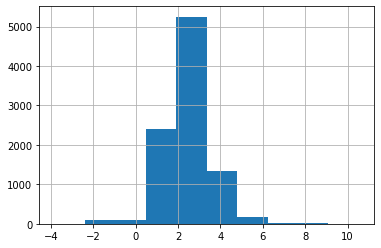

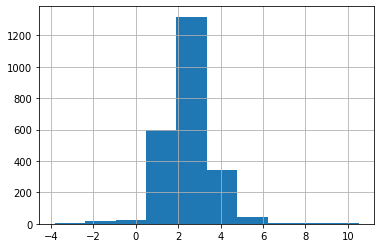

In [26]:
y.hist()
plt.show()
yt.hist()
plt.show()

# Split Data into Training and Validation

In [16]:
X['yb']=y
X['yc']=yc
Xtrain = X.sample(frac=0.9,random_state=101)
Xvalid = X.drop(Xtrain.index)
ybtrain = Xtrain['yb']
yctrain = Xtrain['yc']
ybvalid = Xvalid['yb']
ycvalid = Xvalid['yc']
X = X.drop(columns=['yb','yc'])

# Create Plot of MSE vs Smoothing Factor 







Epoch 1/500
8480/8480 [==============================] - 1s 63us/step - loss: 0.4433
Epoch 2/500
8480/8480 [==============================] - 0s 45us/step - loss: 0.0341
Epoch 3/500
8480/8480 [==============================] - 0s 43us/step - loss: 0.0156
Epoch 4/500
8480/8480 [==============================] - 0s 45us/step - loss: 0.0100
Epoch 5/500
8480/8480 [==============================] - 0s 43us/step - loss: 0.0072
Epoch 6/500
8480/8480 [==============================] - 0s 45us/step - loss: 0.0057
Epoch 7/500
8480/8480 [==============================] - 0s 43us/step - loss: 0.0044
Epoch 8/500
8480/8480 [==============================] - 0s 44us/step - loss: 0.0040
Epoch 9/500
8480/8480 [==============================] - 0s 44us/step - loss: 0.0039
Epoch 10/500
8480/8480 [==============================] - 0s 45us/step - loss: 0.0034
Epoch 11/500
8480/8480 [==============================] - 0s 43us/step - loss: 0.0062
Epoch 12/500
8480/8480 [==============================] -

8480/8480 [==============================] - 0s 43us/step - loss: 1.7965e-04
Epoch 81/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.1802e-04
Epoch 82/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.4644e-04
Epoch 83/500
8480/8480 [==============================] - 0s 43us/step - loss: 5.4436e-05
Epoch 84/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.1792e-05
Epoch 85/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.5305e-04
Epoch 86/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.4313e-05
Epoch 87/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.6435e-04
Epoch 88/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.1465e-04
Epoch 89/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.6167e-04
Epoch 90/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.2572e-05
Epoch 91/500
8480/8480 

8480/8480 [==============================] - 0s 42us/step - loss: 1.0542e-04
Epoch 171/500
8480/8480 [==============================] - 0s 43us/step - loss: 4.3229e-05
Epoch 172/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.1094e-04
Epoch 173/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.2928e-05
Epoch 174/500
8480/8480 [==============================] - 0s 43us/step - loss: 5.9441e-05
Epoch 175/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.2375e-04
Epoch 176/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.1116e-05
Epoch 177/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.4998e-04
Epoch 178/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.0112e-05
Epoch 179/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.4646e-05
Epoch 180/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.2132e-05
Epoch 181/500

8480/8480 [==============================] - 0s 42us/step - loss: 1.9857e-05
Epoch 261/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.5574e-04
Epoch 262/500
8480/8480 [==============================] - 0s 41us/step - loss: 5.0166e-05
Epoch 263/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.9256e-05
Epoch 264/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.4196e-04
Epoch 265/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.1099e-05
Epoch 266/500
8480/8480 [==============================] - 0s 43us/step - loss: 4.3421e-05
Epoch 267/500
8480/8480 [==============================] - 0s 41us/step - loss: 7.6257e-05
Epoch 268/500
8480/8480 [==============================] - 0s 41us/step - loss: 3.9811e-05
Epoch 269/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.0086e-05
Epoch 270/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.5841e-04
Epoch 271/500

Epoch 350/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.5709e-05
Epoch 351/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.6139e-06
Epoch 352/500
8480/8480 [==============================] - 0s 41us/step - loss: 8.3284e-05
Epoch 353/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.7568e-05
Epoch 354/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.4535e-05
Epoch 355/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.4438e-05
Epoch 356/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.3369e-04
Epoch 357/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.6583e-06
Epoch 358/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.8573e-05
Epoch 359/500
8480/8480 [==============================] - 0s 41us/step - loss: 9.6802e-05
Epoch 360/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.7888e-05

8480/8480 [==============================] - 0s 42us/step - loss: 1.4520e-05
Epoch 441/500
8480/8480 [==============================] - 0s 43us/step - loss: 4.7822e-05
Epoch 442/500
8480/8480 [==============================] - 0s 41us/step - loss: 7.1147e-05
Epoch 443/500
8480/8480 [==============================] - 0s 41us/step - loss: 2.4599e-05
Epoch 444/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.6220e-05
Epoch 445/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.3983e-05
Epoch 446/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.4922e-05
Epoch 447/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.9850e-04
Epoch 448/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.1976e-05
Epoch 449/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.6986e-06
Epoch 450/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.0140e-05
Epoch 451/500

8480/8480 [==============================] - 0s 42us/step - loss: 4.9904e-05
Epoch 30/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.2305e-05
Epoch 31/500
8480/8480 [==============================] - 0s 41us/step - loss: 2.3025e-05
Epoch 32/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.3468e-05
Epoch 33/500
8480/8480 [==============================] - 0s 43us/step - loss: 9.9410e-05
Epoch 34/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.2398e-05
Epoch 35/500
8480/8480 [==============================] - 0s 41us/step - loss: 8.9445e-06
Epoch 36/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.8123e-05
Epoch 37/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.7887e-04
Epoch 38/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.5252e-06
Epoch 39/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.7735e-06
Epoch 40/500
8480/8480 

Epoch 120/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.3484e-05
Epoch 121/500
8480/8480 [==============================] - 0s 43us/step - loss: 4.4454e-05
Epoch 122/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.2865e-05
Epoch 123/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.1762e-05
Epoch 124/500
8480/8480 [==============================] - 0s 43us/step - loss: 4.5063e-05
Epoch 125/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.0546e-04
Epoch 126/500
8480/8480 [==============================] - 0s 41us/step - loss: 2.7063e-06
Epoch 127/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.2252e-05
Epoch 128/500
8480/8480 [==============================] - 0s 41us/step - loss: 4.3894e-05
Epoch 129/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.2311e-05
Epoch 130/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.3749e-05

8480/8480 [==============================] - 0s 42us/step - loss: 5.7614e-05
Epoch 211/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.5323e-06
Epoch 212/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.3400e-05
Epoch 213/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.8746e-05
Epoch 214/500
8480/8480 [==============================] - 0s 43us/step - loss: 4.1982e-05
Epoch 215/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.1633e-05
Epoch 216/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.7619e-05
Epoch 217/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.8745e-06
Epoch 218/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.3098e-05
Epoch 219/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.8756e-05
Epoch 220/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.2754e-06
Epoch 221/500

8480/8480 [==============================] - 0s 42us/step - loss: 2.9051e-05
Epoch 301/500
8480/8480 [==============================] - 0s 41us/step - loss: 2.0815e-05
Epoch 302/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.7834e-05
Epoch 303/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.2344e-05
Epoch 304/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.7566e-05
Epoch 305/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.1431e-05
Epoch 306/500
8480/8480 [==============================] - 0s 43us/step - loss: 4.0246e-05
Epoch 307/500
8480/8480 [==============================] - 0s 41us/step - loss: 2.0293e-05
Epoch 308/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.3585e-05
Epoch 309/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.1960e-05
Epoch 310/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.8564e-05
Epoch 311/500

Epoch 390/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.4775e-06
Epoch 391/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.3732e-05
Epoch 392/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.1557e-05
Epoch 393/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.4376e-05
Epoch 394/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.3854e-05
Epoch 395/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.9246e-05
Epoch 396/500
8480/8480 [==============================] - 0s 41us/step - loss: 4.4844e-06
Epoch 397/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.4911e-05
Epoch 398/500
8480/8480 [==============================] - 0s 41us/step - loss: 2.0372e-05
Epoch 399/500
8480/8480 [==============================] - 0s 41us/step - loss: 2.0204e-05
Epoch 400/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.5172e-05

8480/8480 [==============================] - 0s 42us/step - loss: 2.5043e-05
Epoch 481/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.4406e-05
Epoch 482/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.0711e-05
Epoch 483/500
8480/8480 [==============================] - 0s 41us/step - loss: 2.8142e-05
Epoch 484/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.4597e-05
Epoch 485/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.9637e-05
Epoch 486/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.2766e-05
Epoch 487/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.4014e-05
Epoch 488/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.0496e-05
Epoch 489/500
8480/8480 [==============================] - 0s 43us/step - loss: 4.8538e-05
Epoch 490/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.6338e-05
Epoch 491/500

8480/8480 [==============================] - 0s 43us/step - loss: 1.4048e-05
Epoch 71/500
8480/8480 [==============================] - 0s 41us/step - loss: 3.3484e-05
Epoch 72/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.5357e-06
Epoch 73/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.2845e-05
Epoch 74/500
8480/8480 [==============================] - 0s 41us/step - loss: 3.0290e-05
Epoch 75/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.9622e-05
Epoch 76/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.1915e-05
Epoch 77/500
8480/8480 [==============================] - 0s 41us/step - loss: 2.1642e-05
Epoch 78/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.0071e-05
Epoch 79/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.2836e-05
Epoch 80/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.4799e-05
Epoch 81/500
8480/8480 

8480/8480 [==============================] - 0s 42us/step - loss: 8.1183e-07
Epoch 161/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.3870e-05
Epoch 162/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.4940e-05
Epoch 163/500
8480/8480 [==============================] - 0s 41us/step - loss: 3.1000e-05
Epoch 164/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.2845e-05
Epoch 165/500
8480/8480 [==============================] - 0s 41us/step - loss: 3.8180e-05
Epoch 166/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.1645e-05
Epoch 167/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.8549e-05
Epoch 168/500
8480/8480 [==============================] - 0s 41us/step - loss: 8.6590e-06
Epoch 169/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.7816e-05
Epoch 170/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.2133e-05
Epoch 171/500

8480/8480 [==============================] - 0s 42us/step - loss: 3.1122e-05
Epoch 251/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.9230e-05
Epoch 252/500
8480/8480 [==============================] - 0s 41us/step - loss: 4.6080e-05
Epoch 253/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.8290e-06
Epoch 254/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.1118e-05
Epoch 255/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.0774e-05
Epoch 256/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.0271e-06
Epoch 257/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.7799e-05
Epoch 258/500
8480/8480 [==============================] - 0s 41us/step - loss: 2.5598e-05
Epoch 259/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.4468e-06
Epoch 260/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.1976e-05
Epoch 261/500

8480/8480 [==============================] - 0s 43us/step - loss: 1.1838e-05
Epoch 341/500
8480/8480 [==============================] - 0s 41us/step - loss: 2.8730e-05
Epoch 342/500
8480/8480 [==============================] - 0s 41us/step - loss: 4.4068e-07
Epoch 343/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.6311e-05
Epoch 344/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.2830e-05
Epoch 345/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.7125e-06
Epoch 346/500
8480/8480 [==============================] - 0s 41us/step - loss: 3.5217e-05
Epoch 347/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.7764e-05
Epoch 348/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.0251e-05
Epoch 349/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.5151e-05
Epoch 350/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.0945e-06
Epoch 351/500

8480/8480 [==============================] - 0s 41us/step - loss: 1.5646e-05
Epoch 431/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.0671e-05
Epoch 432/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.8779e-05
Epoch 433/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.3473e-05
Epoch 434/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.8754e-05
Epoch 435/500
8480/8480 [==============================] - 0s 41us/step - loss: 7.1592e-06
Epoch 436/500
8480/8480 [==============================] - 0s 41us/step - loss: 2.6604e-05
Epoch 437/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.1215e-05
Epoch 438/500
8480/8480 [==============================] - 0s 42us/step - loss: 8.0378e-06
Epoch 439/500
8480/8480 [==============================] - 0s 41us/step - loss: 5.0126e-05
Epoch 440/500
8480/8480 [==============================] - 0s 42us/step - loss: 9.1980e-06
Epoch 441/500

8480/8480 [==============================] - 0s 42us/step - loss: 8.7121e-06
Epoch 20/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.3856e-05
Epoch 21/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.0663e-05
Epoch 22/500
8480/8480 [==============================] - 0s 41us/step - loss: 9.8434e-06
Epoch 23/500
8480/8480 [==============================] - 0s 41us/step - loss: 8.5555e-06
Epoch 24/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.6746e-05
Epoch 25/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.2197e-05
Epoch 26/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.0335e-06
Epoch 27/500
8480/8480 [==============================] - 0s 41us/step - loss: 9.5202e-06
Epoch 28/500
8480/8480 [==============================] - 0s 43us/step - loss: 7.6198e-05
Epoch 29/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.0912e-06
Epoch 30/500
8480/8480 

8480/8480 [==============================] - 0s 43us/step - loss: 9.8998e-06
Epoch 111/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.4607e-05
Epoch 112/500
8480/8480 [==============================] - 0s 41us/step - loss: 9.5719e-06
Epoch 113/500
8480/8480 [==============================] - 0s 43us/step - loss: 3.9966e-05
Epoch 114/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.0513e-06
Epoch 115/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.1584e-05
Epoch 116/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.2610e-06
Epoch 117/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.1855e-05
Epoch 118/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.4348e-06
Epoch 119/500
8480/8480 [==============================] - 0s 41us/step - loss: 5.3487e-05
Epoch 120/500
8480/8480 [==============================] - 0s 43us/step - loss: 7.0149e-06
Epoch 121/500

8480/8480 [==============================] - 0s 42us/step - loss: 4.3337e-06
Epoch 201/500
8480/8480 [==============================] - 0s 43us/step - loss: 3.4515e-05
Epoch 202/500
8480/8480 [==============================] - 0s 43us/step - loss: 4.2418e-05
Epoch 203/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.0653e-07
Epoch 204/500
8480/8480 [==============================] - 0s 42us/step - loss: 9.8332e-08
Epoch 205/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.0116e-05
Epoch 206/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.2104e-05
Epoch 207/500
8480/8480 [==============================] - 0s 43us/step - loss: 3.4892e-05
Epoch 208/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.7963e-06
Epoch 209/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.4312e-06
Epoch 210/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.6297e-05
Epoch 211/500

8480/8480 [==============================] - 0s 42us/step - loss: 8.6390e-06
Epoch 291/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.4920e-05
Epoch 292/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.7796e-05
Epoch 293/500
8480/8480 [==============================] - 0s 41us/step - loss: 2.1042e-07
Epoch 294/500
8480/8480 [==============================] - 0s 42us/step - loss: 9.4511e-06
Epoch 295/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.6015e-05
Epoch 296/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.4146e-07
Epoch 297/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.8103e-05
Epoch 298/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.7159e-06
Epoch 299/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.5151e-05
Epoch 300/500
8480/8480 [==============================] - 0s 41us/step - loss: 2.6008e-06
Epoch 301/500

8480/8480 [==============================] - 0s 43us/step - loss: 3.2622e-05
Epoch 381/500
8480/8480 [==============================] - 0s 42us/step - loss: 8.0187e-06
Epoch 382/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.2117e-05
Epoch 383/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.7674e-05
Epoch 384/500
8480/8480 [==============================] - 0s 41us/step - loss: 2.8408e-06
Epoch 385/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.2381e-05
Epoch 386/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.5858e-05
Epoch 387/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.5646e-06
Epoch 388/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.4031e-05
Epoch 389/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.2409e-05
Epoch 390/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.8063e-06
Epoch 391/500

8480/8480 [==============================] - 0s 41us/step - loss: 2.5024e-07
Epoch 471/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.5720e-06
Epoch 472/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.3032e-05
Epoch 473/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.3518e-05
Epoch 474/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.4658e-05
Epoch 475/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.5937e-05
Epoch 476/500
8480/8480 [==============================] - 0s 46us/step - loss: 1.1096e-06
Epoch 477/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.8509e-06
Epoch 478/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.1850e-05
Epoch 479/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.9846e-06
Epoch 480/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.1155e-05
Epoch 481/500

8480/8480 [==============================] - 0s 41us/step - loss: 1.8346e-05
Epoch 60/500
8480/8480 [==============================] - 0s 43us/step - loss: 5.9006e-07
Epoch 61/500
8480/8480 [==============================] - 0s 41us/step - loss: 4.6842e-05
Epoch 62/500
8480/8480 [==============================] - 0s 41us/step - loss: 6.4620e-06
Epoch 63/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.3697e-05
Epoch 64/500
8480/8480 [==============================] - 0s 43us/step - loss: 7.0612e-06
Epoch 65/500
8480/8480 [==============================] - 0s 41us/step - loss: 2.9995e-05
Epoch 66/500
8480/8480 [==============================] - 0s 41us/step - loss: 8.9878e-07
Epoch 67/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.4657e-05
Epoch 68/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.3461e-06
Epoch 69/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.3315e-05
Epoch 70/500
8480/8480 

8480/8480 [==============================] - 0s 43us/step - loss: 1.7052e-05
Epoch 150/500
8480/8480 [==============================] - 0s 46us/step - loss: 1.5494e-05
Epoch 151/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.7813e-05
Epoch 152/500
8480/8480 [==============================] - 0s 43us/step - loss: 3.2295e-05
Epoch 153/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.8704e-06
Epoch 154/500
8480/8480 [==============================] - 0s 43us/step - loss: 5.0397e-05
Epoch 155/500
8480/8480 [==============================] - 0s 44us/step - loss: 1.0805e-07
Epoch 156/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.8912e-06
Epoch 157/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.2688e-05
Epoch 158/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.4002e-05
Epoch 159/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.3500e-06
Epoch 160/500

8480/8480 [==============================] - 0s 43us/step - loss: 5.5001e-05
Epoch 240/500
8480/8480 [==============================] - 0s 42us/step - loss: 8.9032e-06
Epoch 241/500
8480/8480 [==============================] - 0s 42us/step - loss: 9.9143e-07
Epoch 242/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.6748e-05
Epoch 243/500
8480/8480 [==============================] - 0s 43us/step - loss: 5.3658e-05
Epoch 244/500
8480/8480 [==============================] - 0s 41us/step - loss: 3.8060e-07
Epoch 245/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.1639e-05
Epoch 246/500
8480/8480 [==============================] - 0s 41us/step - loss: 5.7391e-06
Epoch 247/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.9407e-05
Epoch 248/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.4411e-06
Epoch 249/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.4400e-06
Epoch 250/500

8480/8480 [==============================] - 0s 42us/step - loss: 1.5920e-05
Epoch 330/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.3502e-05
Epoch 331/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.4355e-05
Epoch 332/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.0660e-05
Epoch 333/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.2680e-05
Epoch 334/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.7900e-05
Epoch 335/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.4474e-06
Epoch 336/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.8865e-05
Epoch 337/500
8480/8480 [==============================] - 0s 42us/step - loss: 9.4299e-06
Epoch 338/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.7571e-05
Epoch 339/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.1851e-05
Epoch 340/500

8480/8480 [==============================] - 0s 42us/step - loss: 1.2832e-06
Epoch 420/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.3784e-05
Epoch 421/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.1728e-05
Epoch 422/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.7055e-06
Epoch 423/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.8706e-05
Epoch 424/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.6461e-05
Epoch 425/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.0214e-06
Epoch 426/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.1087e-05
Epoch 427/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.2355e-06
Epoch 428/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.8984e-06
Epoch 429/500
8480/8480 [==============================] - 0s 42us/step - loss: 8.1786e-06
Epoch 430/500

8480/8480 [==============================] - 0s 43us/step - loss: 1.5487e-05
Epoch 9/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.8743e-05
Epoch 10/500
8480/8480 [==============================] - 0s 42us/step - loss: 9.1714e-06
Epoch 11/500
8480/8480 [==============================] - 0s 41us/step - loss: 6.0868e-07
Epoch 12/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.4344e-05
Epoch 13/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.8454e-05
Epoch 14/500
8480/8480 [==============================] - 0s 41us/step - loss: 9.4250e-06
Epoch 15/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.4288e-05
Epoch 16/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.2584e-05
Epoch 17/500
8480/8480 [==============================] - 0s 42us/step - loss: 8.3813e-07
Epoch 18/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.8555e-05
Epoch 19/500
8480/8480 [

8480/8480 [==============================] - 0s 42us/step - loss: 4.2046e-06
Epoch 100/500
8480/8480 [==============================] - 0s 43us/step - loss: 3.9251e-05
Epoch 101/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.8849e-07
Epoch 102/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.1565e-05
Epoch 103/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.4519e-05
Epoch 104/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.8878e-05
Epoch 105/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.1885e-07
Epoch 106/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.5771e-05
Epoch 107/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.6422e-06
Epoch 108/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.9309e-06
Epoch 109/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.6383e-06
Epoch 110/500

8480/8480 [==============================] - 0s 42us/step - loss: 2.2961e-07
Epoch 190/500
8480/8480 [==============================] - 0s 42us/step - loss: 8.1859e-06
Epoch 191/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.2082e-05
Epoch 192/500
8480/8480 [==============================] - 0s 41us/step - loss: 2.5412e-05
Epoch 193/500
8480/8480 [==============================] - 0s 41us/step - loss: 4.3503e-06
Epoch 194/500
8480/8480 [==============================] - 0s 43us/step - loss: 3.7141e-05
Epoch 195/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.9140e-07
Epoch 196/500
8480/8480 [==============================] - 0s 42us/step - loss: 9.1626e-06
Epoch 197/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.2053e-05
Epoch 198/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.9312e-06
Epoch 199/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.6088e-06
Epoch 200/500

8480/8480 [==============================] - 0s 42us/step - loss: 2.9337e-05
Epoch 280/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.3387e-06
Epoch 281/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.4269e-05
Epoch 282/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.9458e-05
Epoch 283/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.1488e-05
Epoch 284/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.0495e-05
Epoch 285/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.2462e-05
Epoch 286/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.4769e-05
Epoch 287/500
8480/8480 [==============================] - 0s 41us/step - loss: 4.7614e-07
Epoch 288/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.8374e-05
Epoch 289/500
8480/8480 [==============================] - 0s 43us/step - loss: 3.5595e-05
Epoch 290/500

Epoch 369/500
8480/8480 [==============================] - 0s 58us/step - loss: 3.9642e-05
Epoch 370/500
8480/8480 [==============================] - 0s 54us/step - loss: 9.8704e-07
Epoch 371/500
8480/8480 [==============================] - 0s 55us/step - loss: 3.0308e-05
Epoch 372/500
8480/8480 [==============================] - 0s 49us/step - loss: 1.6234e-07
Epoch 373/500
8480/8480 [==============================] - 0s 44us/step - loss: 2.7766e-06
Epoch 374/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.4178e-05
Epoch 375/500
8480/8480 [==============================] - 0s 42us/step - loss: 9.7895e-06
Epoch 376/500
8480/8480 [==============================] - 0s 41us/step - loss: 6.8019e-06
Epoch 377/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.9388e-05
Epoch 378/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.9179e-07
Epoch 379/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.4316e-05

8480/8480 [==============================] - 0s 42us/step - loss: 1.5993e-07
Epoch 460/500
8480/8480 [==============================] - 0s 42us/step - loss: 9.7621e-06
Epoch 461/500
8480/8480 [==============================] - 0s 41us/step - loss: 3.3378e-05
Epoch 462/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.8920e-06
Epoch 463/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.3459e-05
Epoch 464/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.8843e-06
Epoch 465/500
8480/8480 [==============================] - 0s 43us/step - loss: 4.2378e-05
Epoch 466/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.3580e-06
Epoch 467/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.2888e-05
Epoch 468/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.5030e-05
Epoch 469/500
8480/8480 [==============================] - 0s 43us/step - loss: 6.9823e-06
Epoch 470/500

8480/8480 [==============================] - 0s 41us/step - loss: 8.9527e-06
Epoch 49/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.6334e-06
Epoch 50/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.9704e-05
Epoch 51/500
8480/8480 [==============================] - 0s 41us/step - loss: 6.3009e-06
Epoch 52/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.1933e-05
Epoch 53/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.4080e-05
Epoch 54/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.0990e-07
Epoch 55/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.8482e-05
Epoch 56/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.0643e-05
Epoch 57/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.4861e-05
Epoch 58/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.0606e-05
Epoch 59/500
8480/8480 

8480/8480 [==============================] - 0s 42us/step - loss: 2.1901e-06
Epoch 139/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.9028e-05
Epoch 140/500
8480/8480 [==============================] - 0s 47us/step - loss: 5.2253e-07
Epoch 141/500
8480/8480 [==============================] - 0s 43us/step - loss: 7.3161e-06
Epoch 142/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.5022e-05
Epoch 143/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.4660e-05
Epoch 144/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.7545e-07
Epoch 145/500
8480/8480 [==============================] - 0s 44us/step - loss: 1.3349e-05
Epoch 146/500
8480/8480 [==============================] - 0s 43us/step - loss: 8.7468e-06
Epoch 147/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.4739e-05
Epoch 148/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.7572e-06
Epoch 149/500

8480/8480 [==============================] - 0s 46us/step - loss: 2.9612e-05
Epoch 229/500
8480/8480 [==============================] - 0s 43us/step - loss: 6.2659e-06
Epoch 230/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.4764e-06
Epoch 231/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.2900e-05
Epoch 232/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.7296e-06
Epoch 233/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.1005e-07
Epoch 234/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.5002e-06
Epoch 235/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.8457e-05
Epoch 236/500
8480/8480 [==============================] - 0s 43us/step - loss: 7.9023e-06
Epoch 237/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.1151e-05
Epoch 238/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.2104e-05
Epoch 239/500

8480/8480 [==============================] - 0s 43us/step - loss: 1.0764e-05
Epoch 319/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.6969e-05
Epoch 320/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.2727e-07
Epoch 321/500
8480/8480 [==============================] - 0s 44us/step - loss: 2.3643e-05
Epoch 322/500
8480/8480 [==============================] - 0s 41us/step - loss: 3.0271e-06
Epoch 323/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.5117e-06
Epoch 324/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.4953e-05
Epoch 325/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.5859e-05
Epoch 326/500
8480/8480 [==============================] - 0s 41us/step - loss: 2.4744e-06
Epoch 327/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.0541e-05
Epoch 328/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.0791e-05
Epoch 329/500

8480/8480 [==============================] - 0s 43us/step - loss: 1.5904e-06
Epoch 409/500
8480/8480 [==============================] - 0s 41us/step - loss: 3.8049e-06
Epoch 410/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.2235e-05
Epoch 411/500
8480/8480 [==============================] - 0s 43us/step - loss: 9.5751e-06
Epoch 412/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.7161e-05
Epoch 413/500
8480/8480 [==============================] - 0s 41us/step - loss: 7.1551e-06
Epoch 414/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.1648e-05
Epoch 415/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.6233e-05
Epoch 416/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.8190e-06
Epoch 417/500
8480/8480 [==============================] - 0s 41us/step - loss: 2.7126e-06
Epoch 418/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.2825e-05
Epoch 419/500

Epoch 498/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.1442e-05
Epoch 499/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.1326e-05
Epoch 500/500
942/942 [==============================] - 0s 10us/step
0.3 8.244147745298913e-07
Epoch 1/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.2534e-04
Epoch 2/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.2813e-05
Epoch 3/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.6843e-06
Epoch 4/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.4009e-06
Epoch 5/500
8480/8480 [==============================] - 0s 42us/step - loss: 8.3534e-06
Epoch 6/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.3186e-05
Epoch 7/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.6224e-06
Epoch 8/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.4767e-05
Epoch 9/50

8480/8480 [==============================] - 0s 43us/step - loss: 4.3508e-06
Epoch 89/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.2490e-05
Epoch 90/500
8480/8480 [==============================] - 0s 42us/step - loss: 8.6169e-06
Epoch 91/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.2098e-06
Epoch 92/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.7280e-05
Epoch 93/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.4823e-06
Epoch 94/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.4654e-05
Epoch 95/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.2421e-06
Epoch 96/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.2767e-05
Epoch 97/500
8480/8480 [==============================] - 0s 42us/step - loss: 8.2735e-06
Epoch 98/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.7117e-06
Epoch 99/500
8480/8480 

8480/8480 [==============================] - 0s 42us/step - loss: 1.0485e-05
Epoch 179/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.4100e-06
Epoch 180/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.9389e-05
Epoch 181/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.1560e-06
Epoch 182/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.6488e-06
Epoch 183/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.1909e-06
Epoch 184/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.0834e-05
Epoch 185/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.0343e-06
Epoch 186/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.5867e-05
Epoch 187/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.7060e-06
Epoch 188/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.2951e-05
Epoch 189/500

8480/8480 [==============================] - 0s 42us/step - loss: 2.2535e-05
Epoch 269/500
8480/8480 [==============================] - 0s 41us/step - loss: 5.2412e-06
Epoch 270/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.4068e-06
Epoch 271/500
8480/8480 [==============================] - 0s 42us/step - loss: 9.1399e-06
Epoch 272/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.2511e-06
Epoch 273/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.4510e-06
Epoch 274/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.2119e-05
Epoch 275/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.4093e-06
Epoch 276/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.2296e-05
Epoch 277/500
8480/8480 [==============================] - 0s 44us/step - loss: 8.7234e-06
Epoch 278/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.1504e-05
Epoch 279/500

8480/8480 [==============================] - 0s 42us/step - loss: 2.2608e-05
Epoch 359/500
8480/8480 [==============================] - 0s 42us/step - loss: 9.3067e-07
Epoch 360/500
8480/8480 [==============================] - 0s 41us/step - loss: 4.0495e-07
Epoch 361/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.2796e-05
Epoch 362/500
8480/8480 [==============================] - 0s 41us/step - loss: 9.8971e-06
Epoch 363/500
8480/8480 [==============================] - 0s 41us/step - loss: 3.6587e-06
Epoch 364/500
8480/8480 [==============================] - 0s 43us/step - loss: 4.6584e-06
Epoch 365/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.0042e-05
Epoch 366/500
8480/8480 [==============================] - 0s 41us/step - loss: 3.6281e-07
Epoch 367/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.5536e-08
Epoch 368/500
8480/8480 [==============================] - 0s 43us/step - loss: 5.1061e-07
Epoch 369/500

Epoch 448/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.2933e-05
Epoch 449/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.3504e-06
Epoch 450/500
8480/8480 [==============================] - 0s 41us/step - loss: 2.5636e-06
Epoch 451/500
8480/8480 [==============================] - 0s 42us/step - loss: 9.2328e-06
Epoch 452/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.4784e-06
Epoch 453/500
8480/8480 [==============================] - 0s 41us/step - loss: 9.9258e-06
Epoch 454/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.1491e-06
Epoch 455/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.7024e-05
Epoch 456/500
8480/8480 [==============================] - 0s 41us/step - loss: 2.9012e-06
Epoch 457/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.2021e-06
Epoch 458/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.4982e-05

8480/8480 [==============================] - 0s 43us/step - loss: 5.9237e-06
Epoch 38/500
8480/8480 [==============================] - 0s 43us/step - loss: 8.3535e-06
Epoch 39/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.1488e-05
Epoch 40/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.2378e-06
Epoch 41/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.2118e-07
Epoch 42/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.6529e-05
Epoch 43/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.1921e-06
Epoch 44/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.0339e-05
Epoch 45/500
8480/8480 [==============================] - 0s 41us/step - loss: 7.9317e-07
Epoch 46/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.3553e-05
Epoch 47/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.4088e-06
Epoch 48/500
8480/8480 

8480/8480 [==============================] - 0s 41us/step - loss: 1.8351e-05
Epoch 128/500
8480/8480 [==============================] - 0s 41us/step - loss: 2.6610e-06
Epoch 129/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.9377e-06
Epoch 130/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.5756e-06
Epoch 131/500
8480/8480 [==============================] - 0s 43us/step - loss: 3.5813e-06
Epoch 132/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.2121e-05
Epoch 133/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.1124e-06
Epoch 134/500
8480/8480 [==============================] - 0s 41us/step - loss: 5.1525e-06
Epoch 135/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.3390e-05
Epoch 136/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.4470e-06
Epoch 137/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.0473e-05
Epoch 138/500

Epoch 217/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.0454e-07
Epoch 218/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.2788e-05
Epoch 219/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.0360e-06
Epoch 220/500
8480/8480 [==============================] - 0s 43us/step - loss: 3.5578e-06
Epoch 221/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.2518e-06
Epoch 222/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.0271e-05
Epoch 223/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.1218e-05
Epoch 224/500
8480/8480 [==============================] - 0s 41us/step - loss: 7.4800e-06
Epoch 225/500
8480/8480 [==============================] - 0s 41us/step - loss: 2.3303e-07
Epoch 226/500
8480/8480 [==============================] - 0s 43us/step - loss: 3.2121e-05
Epoch 227/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.8793e-07

8480/8480 [==============================] - 0s 43us/step - loss: 8.4766e-06
Epoch 308/500
8480/8480 [==============================] - 0s 42us/step - loss: 8.2593e-06
Epoch 309/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.0709e-07
Epoch 310/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.5154e-05
Epoch 311/500
8480/8480 [==============================] - 0s 43us/step - loss: 3.5368e-06
Epoch 312/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.4693e-06
Epoch 313/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.6430e-06
Epoch 314/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.3700e-05
Epoch 315/500
8480/8480 [==============================] - 0s 43us/step - loss: 5.6044e-06
Epoch 316/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.6665e-06
Epoch 317/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.4694e-05
Epoch 318/500

8480/8480 [==============================] - 0s 42us/step - loss: 4.3073e-07
Epoch 398/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.1360e-05
Epoch 399/500
8480/8480 [==============================] - 0s 41us/step - loss: 7.9830e-06
Epoch 400/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.4972e-07
Epoch 401/500
8480/8480 [==============================] - 0s 44us/step - loss: 1.5271e-06
Epoch 402/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.5537e-06
Epoch 403/500
8480/8480 [==============================] - 0s 41us/step - loss: 2.4231e-06
Epoch 404/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.9878e-05
Epoch 405/500
8480/8480 [==============================] - 0s 43us/step - loss: 5.6676e-06
Epoch 406/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.9175e-06
Epoch 407/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.1796e-05
Epoch 408/500

8480/8480 [==============================] - 0s 43us/step - loss: 3.8143e-05
Epoch 488/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.0726e-05
Epoch 489/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.0956e-06
Epoch 490/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.1992e-08
Epoch 491/500
8480/8480 [==============================] - 0s 41us/step - loss: 7.2210e-06
Epoch 492/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.0013e-06
Epoch 493/500
8480/8480 [==============================] - 0s 43us/step - loss: 8.2222e-06
Epoch 494/500
8480/8480 [==============================] - 0s 43us/step - loss: 5.4986e-06
Epoch 495/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.0333e-05
Epoch 496/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.3428e-06
Epoch 497/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.8348e-09
Epoch 498/500

8480/8480 [==============================] - 0s 43us/step - loss: 7.7024e-06
Epoch 77/500
8480/8480 [==============================] - 0s 41us/step - loss: 4.3089e-06
Epoch 78/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.1239e-05
Epoch 79/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.8981e-06
Epoch 80/500
8480/8480 [==============================] - 0s 42us/step - loss: 8.5275e-06
Epoch 81/500
8480/8480 [==============================] - 0s 42us/step - loss: 9.0807e-06
Epoch 82/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.2899e-05
Epoch 83/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.4417e-06
Epoch 84/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.1012e-06
Epoch 85/500
8480/8480 [==============================] - 0s 41us/step - loss: 9.9097e-06
Epoch 86/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.2263e-06
Epoch 87/500
8480/8480 

8480/8480 [==============================] - 0s 42us/step - loss: 3.3791e-05
Epoch 167/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.6055e-06
Epoch 168/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.8918e-08
Epoch 169/500
8480/8480 [==============================] - 0s 41us/step - loss: 8.8573e-06
Epoch 170/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.1347e-05
Epoch 171/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.1329e-07
Epoch 172/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.1700e-05
Epoch 173/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.0924e-05
Epoch 174/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.6910e-07
Epoch 175/500
8480/8480 [==============================] - 0s 41us/step - loss: 7.6904e-06
Epoch 176/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.0905e-06
Epoch 177/500

8480/8480 [==============================] - 0s 42us/step - loss: 9.4135e-08
Epoch 257/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.9694e-06
Epoch 258/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.6789e-05
Epoch 259/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.2585e-05
Epoch 260/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.1736e-08
Epoch 261/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.8592e-06
Epoch 262/500
8480/8480 [==============================] - 0s 42us/step - loss: 8.4141e-06
Epoch 263/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.4885e-06
Epoch 264/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.0476e-07
Epoch 265/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.6490e-05
Epoch 266/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.0412e-06
Epoch 267/500

8480/8480 [==============================] - 0s 43us/step - loss: 1.3686e-05
Epoch 347/500
8480/8480 [==============================] - 0s 43us/step - loss: 7.7647e-06
Epoch 348/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.4172e-06
Epoch 349/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.0616e-06
Epoch 350/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.4437e-06
Epoch 351/500
8480/8480 [==============================] - 0s 41us/step - loss: 5.4607e-06
Epoch 352/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.8631e-06
Epoch 353/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.7075e-05
Epoch 354/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.3919e-06
Epoch 355/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.8524e-06
Epoch 356/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.8505e-06
Epoch 357/500

8480/8480 [==============================] - 0s 43us/step - loss: 1.5384e-05
Epoch 437/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.9187e-07
Epoch 438/500
8480/8480 [==============================] - 0s 41us/step - loss: 6.3952e-06
Epoch 439/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.0070e-06
Epoch 440/500
8480/8480 [==============================] - 0s 41us/step - loss: 2.4279e-05
Epoch 441/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.3444e-06
Epoch 442/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.8220e-06
Epoch 443/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.1778e-07
Epoch 444/500
8480/8480 [==============================] - 0s 43us/step - loss: 9.2441e-06
Epoch 445/500
8480/8480 [==============================] - 0s 43us/step - loss: 3.0608e-06
Epoch 446/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.4396e-06
Epoch 447/500

8480/8480 [==============================] - 0s 43us/step - loss: 1.6814e-05
Epoch 26/500
8480/8480 [==============================] - 0s 42us/step - loss: 8.1881e-06
Epoch 27/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.6478e-06
Epoch 28/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.1110e-05
Epoch 29/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.1424e-06
Epoch 30/500
8480/8480 [==============================] - 0s 41us/step - loss: 3.1807e-05
Epoch 31/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.7112e-06
Epoch 32/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.5505e-06
Epoch 33/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.3253e-06
Epoch 34/500
8480/8480 [==============================] - 0s 43us/step - loss: 9.3755e-06
Epoch 35/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.1562e-05
Epoch 36/500
8480/8480 

8480/8480 [==============================] - 0s 43us/step - loss: 9.4440e-06
Epoch 116/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.4465e-05
Epoch 117/500
8480/8480 [==============================] - 0s 41us/step - loss: 4.1782e-07
Epoch 118/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.7354e-06
Epoch 119/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.9761e-06
Epoch 120/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.2849e-05
Epoch 121/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.5453e-07
Epoch 122/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.7349e-05
Epoch 123/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.2820e-08
Epoch 124/500
8480/8480 [==============================] - 0s 41us/step - loss: 3.0528e-08
Epoch 125/500
8480/8480 [==============================] - 0s 43us/step - loss: 5.0265e-06
Epoch 126/500

8480/8480 [==============================] - 0s 43us/step - loss: 1.9821e-06
Epoch 206/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.8560e-06
Epoch 207/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.0035e-06
Epoch 208/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.7191e-05
Epoch 209/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.5091e-07
Epoch 210/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.5693e-08
Epoch 211/500
8480/8480 [==============================] - 0s 42us/step - loss: 8.8374e-07
Epoch 212/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.4492e-05
Epoch 213/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.9255e-06
Epoch 214/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.0007e-06
Epoch 215/500
8480/8480 [==============================] - 0s 42us/step - loss: 9.2582e-06
Epoch 216/500

8480/8480 [==============================] - 0s 42us/step - loss: 1.1644e-06
Epoch 296/500
8480/8480 [==============================] - 0s 47us/step - loss: 4.1770e-06
Epoch 297/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.6097e-06
Epoch 298/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.0197e-06
Epoch 299/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.3566e-05
Epoch 300/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.3802e-06
Epoch 301/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.5829e-05
Epoch 302/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.4252e-08
Epoch 303/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.4452e-08
Epoch 304/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.8425e-06
Epoch 305/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.0917e-05
Epoch 306/500

8480/8480 [==============================] - 0s 43us/step - loss: 9.5249e-06
Epoch 386/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.7988e-06
Epoch 387/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.4718e-06
Epoch 388/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.2310e-05
Epoch 389/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.3632e-06
Epoch 390/500
8480/8480 [==============================] - 0s 41us/step - loss: 2.8456e-06
Epoch 391/500
8480/8480 [==============================] - 0s 44us/step - loss: 6.1782e-06
Epoch 392/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.7763e-06
Epoch 393/500
8480/8480 [==============================] - 0s 43us/step - loss: 4.4096e-06
Epoch 394/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.0094e-05
Epoch 395/500
8480/8480 [==============================] - ETA: 0s - loss: 1.1269e-0 - 0s 42us/step - lo

8480/8480 [==============================] - 0s 43us/step - loss: 2.3220e-06
Epoch 475/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.0381e-05
Epoch 476/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.1379e-05
Epoch 477/500
8480/8480 [==============================] - 0s 43us/step - loss: 4.9163e-06
Epoch 478/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.0093e-06
Epoch 479/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.0152e-06
Epoch 480/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.3601e-05
Epoch 481/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.6039e-07
Epoch 482/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.2519e-05
Epoch 483/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.0583e-06
Epoch 484/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.5141e-06
Epoch 485/500

8480/8480 [==============================] - 0s 42us/step - loss: 4.4593e-07
Epoch 65/500
8480/8480 [==============================] - 0s 43us/step - loss: 7.8154e-06
Epoch 66/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.5903e-05
Epoch 67/500
8480/8480 [==============================] - 0s 43us/step - loss: 3.2215e-06
Epoch 68/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.2396e-06
Epoch 69/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.3317e-05
Epoch 70/500
8480/8480 [==============================] - 0s 43us/step - loss: 3.2527e-07
Epoch 71/500
8480/8480 [==============================] - 0s 42us/step - loss: 9.0143e-06
Epoch 72/500
8480/8480 [==============================] - 0s 42us/step - loss: 9.1902e-06
Epoch 73/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.3722e-05
Epoch 74/500
8480/8480 [==============================] - 0s 41us/step - loss: 3.5148e-06
Epoch 75/500
8480/8480 

8480/8480 [==============================] - 0s 43us/step - loss: 3.6613e-06
Epoch 155/500
8480/8480 [==============================] - 0s 41us/step - loss: 8.2194e-06
Epoch 156/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.9074e-07
Epoch 157/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.5230e-05
Epoch 158/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.7092e-07
Epoch 159/500
8480/8480 [==============================] - 0s 42us/step - loss: 9.5493e-07
Epoch 160/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.5256e-05
Epoch 161/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.4028e-07
Epoch 162/500
8480/8480 [==============================] - 0s 42us/step - loss: 8.9004e-06
Epoch 163/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.3945e-05
Epoch 164/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.0955e-06
Epoch 165/500

8480/8480 [==============================] - 0s 42us/step - loss: 8.6957e-06
Epoch 245/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.7878e-06
Epoch 246/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.2930e-06
Epoch 247/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.1115e-05
Epoch 248/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.9050e-06
Epoch 249/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.4528e-06
Epoch 250/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.9314e-05
Epoch 251/500
8480/8480 [==============================] - 0s 41us/step - loss: 4.3202e-06
Epoch 252/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.3497e-06
Epoch 253/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.0085e-06
Epoch 254/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.9306e-05
Epoch 255/500

8480/8480 [==============================] - 0s 43us/step - loss: 1.3864e-07
Epoch 335/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.5374e-06
Epoch 336/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.0396e-06
Epoch 337/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.5893e-06
Epoch 338/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.1978e-06
Epoch 339/500
8480/8480 [==============================] - 0s 42us/step - loss: 8.5298e-06
Epoch 340/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.4124e-06
Epoch 341/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.0312e-06
Epoch 342/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.2159e-06
Epoch 343/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.4701e-05
Epoch 344/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.2358e-06
Epoch 345/500

Epoch 424/500
8480/8480 [==============================] - 0s 41us/step - loss: 2.0692e-05
Epoch 425/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.7119e-08
Epoch 426/500
8480/8480 [==============================] - 0s 41us/step - loss: 9.7681e-08
Epoch 427/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.4019e-05
Epoch 428/500
8480/8480 [==============================] - 0s 43us/step - loss: 5.4598e-08
Epoch 429/500
8480/8480 [==============================] - 0s 41us/step - loss: 2.4389e-07
Epoch 430/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.8558e-05
Epoch 431/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.9040e-08
Epoch 432/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.4986e-07
Epoch 433/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.3204e-05
Epoch 434/500
8480/8480 [==============================] - 0s 43us/step - loss: 4.3100e-06

8480/8480 [==============================] - 0s 42us/step - loss: 9.6927e-06
Epoch 14/500
8480/8480 [==============================] - 0s 41us/step - loss: 2.3809e-05
Epoch 15/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.9027e-05
Epoch 16/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.2351e-06
Epoch 17/500
8480/8480 [==============================] - 0s 43us/step - loss: 3.4250e-06
Epoch 18/500
8480/8480 [==============================] - 0s 41us/step - loss: 7.6513e-06
Epoch 19/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.4850e-05
Epoch 20/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.0505e-05
Epoch 21/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.3992e-06
Epoch 22/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.7410e-06
Epoch 23/500
8480/8480 [==============================] - 0s 43us/step - loss: 3.3063e-05
Epoch 24/500
8480/8480 

8480/8480 [==============================] - 0s 43us/step - loss: 1.0938e-05
Epoch 105/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.4052e-08
Epoch 106/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.9458e-06
Epoch 107/500
8480/8480 [==============================] - 0s 43us/step - loss: 6.6944e-06
Epoch 108/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.0075e-05
Epoch 109/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.6021e-08
Epoch 110/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.1411e-08
Epoch 111/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.9727e-05
Epoch 112/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.7106e-07
Epoch 113/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.1966e-05
Epoch 114/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.4721e-07
Epoch 115/500

8480/8480 [==============================] - 0s 43us/step - loss: 1.4094e-05
Epoch 195/500
8480/8480 [==============================] - 0s 41us/step - loss: 6.0198e-06
Epoch 196/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.0506e-08
Epoch 197/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.0619e-05
Epoch 198/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.6756e-06
Epoch 199/500
8480/8480 [==============================] - 0s 41us/step - loss: 5.5838e-06
Epoch 200/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.7115e-05
Epoch 201/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.9570e-06
Epoch 202/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.5778e-06
Epoch 203/500
8480/8480 [==============================] - 0s 42us/step - loss: 8.0238e-06
Epoch 204/500
8480/8480 [==============================] - 0s 44us/step - loss: 1.6544e-07
Epoch 205/500

8480/8480 [==============================] - 0s 42us/step - loss: 7.0618e-09
Epoch 285/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.0768e-09
Epoch 286/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.2669e-07
Epoch 287/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.7470e-05
Epoch 288/500
8480/8480 [==============================] - 0s 43us/step - loss: 8.6784e-08
Epoch 289/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.6914e-07
Epoch 290/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.4722e-05
Epoch 291/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.3654e-06
Epoch 292/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.0435e-06
Epoch 293/500
8480/8480 [==============================] - 0s 42us/step - loss: 8.3619e-06
Epoch 294/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.6994e-05
Epoch 295/500

8480/8480 [==============================] - 0s 42us/step - loss: 2.7670e-05
Epoch 375/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.8421e-08
Epoch 376/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.7834e-05
Epoch 377/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.8169e-07
Epoch 378/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.5177e-06
Epoch 379/500
8480/8480 [==============================] - 0s 42us/step - loss: 9.9040e-06
Epoch 380/500
8480/8480 [==============================] - 0s 41us/step - loss: 4.8985e-06
Epoch 381/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.4960e-07
Epoch 382/500
8480/8480 [==============================] - 0s 43us/step - loss: 7.3511e-06
Epoch 383/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.1093e-05
Epoch 384/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.6313e-07
Epoch 385/500

8480/8480 [==============================] - 0s 42us/step - loss: 1.7334e-05
Epoch 465/500
8480/8480 [==============================] - 0s 45us/step - loss: 7.2645e-06
Epoch 466/500
8480/8480 [==============================] - 0s 46us/step - loss: 2.0962e-06
Epoch 467/500
8480/8480 [==============================] - 0s 42us/step - loss: 9.4980e-06
Epoch 468/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.5774e-08
Epoch 469/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.3990e-06
Epoch 470/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.4335e-05
Epoch 471/500
8480/8480 [==============================] - 0s 44us/step - loss: 1.6938e-07
Epoch 472/500
8480/8480 [==============================] - 0s 43us/step - loss: 7.0275e-06
Epoch 473/500
8480/8480 [==============================] - 0s 43us/step - loss: 8.2557e-06
Epoch 474/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.2414e-07
Epoch 475/500

Epoch 54/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.2934e-06
Epoch 55/500
8480/8480 [==============================] - 0s 42us/step - loss: 9.3916e-06
Epoch 56/500
8480/8480 [==============================] - 0s 42us/step - loss: 8.1112e-07
Epoch 57/500
8480/8480 [==============================] - 0s 41us/step - loss: 2.1113e-05
Epoch 58/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.6699e-06
Epoch 59/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.7211e-05
Epoch 60/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.1254e-07
Epoch 61/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.8853e-07
Epoch 62/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.0521e-05
Epoch 63/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.5487e-06
Epoch 64/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.1005e-06
Epoch 65/5

8480/8480 [==============================] - 0s 43us/step - loss: 4.5557e-06
Epoch 145/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.4916e-07
Epoch 146/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.0246e-06
Epoch 147/500
8480/8480 [==============================] - 0s 43us/step - loss: 3.3253e-06
Epoch 148/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.0999e-05
Epoch 149/500
8480/8480 [==============================] - 0s 42us/step - loss: 8.0558e-06
Epoch 150/500
8480/8480 [==============================] - 0s 43us/step - loss: 4.1930e-08
Epoch 151/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.3391e-05
Epoch 152/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.6810e-06
Epoch 153/500
8480/8480 [==============================] - 0s 43us/step - loss: 9.2604e-06
Epoch 154/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.6881e-06
Epoch 155/500

8480/8480 [==============================] - 0s 42us/step - loss: 3.4466e-08
Epoch 235/500
8480/8480 [==============================] - 0s 42us/step - loss: 8.0355e-08
Epoch 236/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.8267e-05
Epoch 237/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.2115e-08
Epoch 238/500
8480/8480 [==============================] - 0s 41us/step - loss: 5.6491e-06
Epoch 239/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.7224e-06
Epoch 240/500
8480/8480 [==============================] - 0s 41us/step - loss: 6.4410e-06
Epoch 241/500
8480/8480 [==============================] - 0s 43us/step - loss: 5.1242e-06
Epoch 242/500
8480/8480 [==============================] - 0s 41us/step - loss: 2.6746e-05
Epoch 243/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.7579e-06
Epoch 244/500
8480/8480 [==============================] - 0s 43us/step - loss: 3.9352e-06
Epoch 245/500

8480/8480 [==============================] - 0s 43us/step - loss: 2.1225e-07: 0s - loss: 2.1261e-0
Epoch 325/500
8480/8480 [==============================] - 0s 41us/step - loss: 8.6180e-06
Epoch 326/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.7066e-06
Epoch 327/500
8480/8480 [==============================] - 0s 43us/step - loss: 4.0989e-06
Epoch 328/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.3999e-05
Epoch 329/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.7833e-06
Epoch 330/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.0408e-08
Epoch 331/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.2352e-05
Epoch 332/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.6480e-06
Epoch 333/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.1856e-05
Epoch 334/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.

Epoch 414/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.4462e-06
Epoch 415/500
8480/8480 [==============================] - 0s 42us/step - loss: 9.3412e-06
Epoch 416/500
8480/8480 [==============================] - 0s 41us/step - loss: 9.8832e-06
Epoch 417/500
8480/8480 [==============================] - 0s 43us/step - loss: 7.8070e-10
Epoch 418/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.6750e-06
Epoch 419/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.0602e-06
Epoch 420/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.5571e-05
Epoch 421/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.5353e-06
Epoch 422/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.4620e-09
Epoch 423/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.2776e-05
Epoch 424/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.2367e-06

8480/8480 [==============================] - 0s 43us/step - loss: 6.1264e-06
Epoch 4/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.0670e-06
Epoch 5/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.8186e-06
Epoch 6/500
8480/8480 [==============================] - 0s 43us/step - loss: 3.5082e-06
Epoch 7/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.7327e-05: 0s - loss: 2.1027e
Epoch 8/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.7580e-06
Epoch 9/500
8480/8480 [==============================] - 0s 43us/step - loss: 9.3593e-06
Epoch 10/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.8391e-06
Epoch 11/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.8639e-05
Epoch 12/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.0913e-06: 0s - loss: 4.8
Epoch 13/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.79

8480/8480 [==============================] - 0s 43us/step - loss: 1.8729e-05
Epoch 94/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.6855e-07
Epoch 95/500
8480/8480 [==============================] - 0s 41us/step - loss: 4.7446e-06
Epoch 96/500
8480/8480 [==============================] - 0s 41us/step - loss: 8.1757e-07
Epoch 97/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.3484e-06
Epoch 98/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.7847e-05
Epoch 99/500
8480/8480 [==============================] - 0s 42us/step - loss: 8.3756e-07
Epoch 100/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.4662e-05
Epoch 101/500
8480/8480 [==============================] - 0s 42us/step - loss: 9.0199e-06
Epoch 102/500
8480/8480 [==============================] - 0s 42us/step - loss: 8.8579e-06
Epoch 103/500
8480/8480 [==============================] - 0s 41us/step - loss: 5.5317e-09
Epoch 104/500
8480/

8480/8480 [==============================] - 0s 42us/step - loss: 6.2106e-06
Epoch 184/500
8480/8480 [==============================] - 0s 44us/step - loss: 1.0544e-05
Epoch 185/500
8480/8480 [==============================] - 0s 41us/step - loss: 2.3831e-05
Epoch 186/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.5120e-09
Epoch 187/500
8480/8480 [==============================] - 0s 43us/step - loss: 3.7082e-08
Epoch 188/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.1722e-05
Epoch 189/500
8480/8480 [==============================] - 0s 44us/step - loss: 5.6835e-09
Epoch 190/500
8480/8480 [==============================] - 0s 41us/step - loss: 2.8336e-06
Epoch 191/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.3058e-05
Epoch 192/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.0436e-06
Epoch 193/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.4736e-07
Epoch 194/500

8480/8480 [==============================] - 0s 43us/step - loss: 4.1047e-06
Epoch 274/500
8480/8480 [==============================] - 0s 43us/step - loss: 5.5522e-06
Epoch 275/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.5266e-05
Epoch 276/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.5460e-06
Epoch 277/500
8480/8480 [==============================] - 0s 43us/step - loss: 6.8620e-06
Epoch 278/500
8480/8480 [==============================] - 0s 42us/step - loss: 9.0945e-06
Epoch 279/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.5809e-08
Epoch 280/500
8480/8480 [==============================] - 0s 43us/step - loss: 7.0838e-07
Epoch 281/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.5550e-05
Epoch 282/500
8480/8480 [==============================] - 0s 41us/step - loss: 4.8567e-07
Epoch 283/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.5023e-06
Epoch 284/500

8480/8480 [==============================] - 0s 42us/step - loss: 5.0723e-07
Epoch 364/500
8480/8480 [==============================] - 0s 43us/step - loss: 3.1607e-06
Epoch 365/500
8480/8480 [==============================] - 0s 43us/step - loss: 6.4917e-06
Epoch 366/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.1551e-07
Epoch 367/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.6500e-06
Epoch 368/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.7185e-05
Epoch 369/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.8738e-08
Epoch 370/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.9761e-06
Epoch 371/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.0005e-05
Epoch 372/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.2461e-06
Epoch 373/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.4916e-05
Epoch 374/500

8480/8480 [==============================] - 0s 43us/step - loss: 2.1982e-07
Epoch 454/500
8480/8480 [==============================] - 0s 43us/step - loss: 5.9778e-08
Epoch 455/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.8088e-05
Epoch 456/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.2128e-06
Epoch 457/500
8480/8480 [==============================] - 0s 41us/step - loss: 5.4066e-06
Epoch 458/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.2267e-06
Epoch 459/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.7957e-06
Epoch 460/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.7015e-05
Epoch 461/500
8480/8480 [==============================] - 0s 43us/step - loss: 5.8848e-06
Epoch 462/500
8480/8480 [==============================] - 0s 47us/step - loss: 3.8524e-06
Epoch 463/500
8480/8480 [==============================] - 0s 43us/step - loss: 7.8259e-07
Epoch 464/500

8480/8480 [==============================] - 0s 42us/step - loss: 1.0262e-05
Epoch 43/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.9999e-06
Epoch 44/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.3638e-07
Epoch 45/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.0735e-05
Epoch 46/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.1125e-07
Epoch 47/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.8722e-06
Epoch 48/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.5601e-05
Epoch 49/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.2555e-07
Epoch 50/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.9891e-05
Epoch 51/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.1951e-05
Epoch 52/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.1465e-07
Epoch 53/500
8480/8480 

8480/8480 [==============================] - 0s 43us/step - loss: 4.0668e-06
Epoch 133/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.7878e-07
Epoch 134/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.5803e-06
Epoch 135/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.7094e-05
Epoch 136/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.6398e-07
Epoch 137/500
8480/8480 [==============================] - 0s 41us/step - loss: 5.1710e-08
Epoch 138/500
8480/8480 [==============================] - 0s 42us/step - loss: 8.6399e-06
Epoch 139/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.7023e-06
Epoch 140/500
8480/8480 [==============================] - 0s 41us/step - loss: 9.1993e-07
Epoch 141/500
8480/8480 [==============================] - 0s 44us/step - loss: 8.6620e-06
Epoch 142/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.3681e-06
Epoch 143/500

8480/8480 [==============================] - 0s 43us/step - loss: 2.0318e-05
Epoch 223/500
8480/8480 [==============================] - 0s 42us/step - loss: 9.6491e-09
Epoch 224/500
8480/8480 [==============================] - 0s 43us/step - loss: 4.1460e-06
Epoch 225/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.6009e-05
Epoch 226/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.4784e-08
Epoch 227/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.7997e-07
Epoch 228/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.6019e-05
Epoch 229/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.4581e-06
Epoch 230/500
8480/8480 [==============================] - 0s 43us/step - loss: 5.8424e-06
Epoch 231/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.6664e-06
Epoch 232/500
8480/8480 [==============================] - 0s 41us/step - loss: 7.6294e-07
Epoch 233/500

8480/8480 [==============================] - 0s 42us/step - loss: 1.6727e-08
Epoch 313/500
8480/8480 [==============================] - 0s 43us/step - loss: 3.2861e-09
Epoch 314/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.0974e-05
Epoch 315/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.2092e-06
Epoch 316/500
8480/8480 [==============================] - 0s 43us/step - loss: 5.9733e-06
Epoch 317/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.2692e-05
Epoch 318/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.7143e-07
Epoch 319/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.0167e-06
Epoch 320/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.0579e-05
Epoch 321/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.5476e-05: 0s - loss: 1.8513e-
Epoch 322/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.6

Epoch 402/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.0887e-08
Epoch 403/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.0713e-05
Epoch 404/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.4203e-06
Epoch 405/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.2023e-06
Epoch 406/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.2709e-05
Epoch 407/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.3717e-06
Epoch 408/500
8480/8480 [==============================] - 0s 42us/step - loss: 9.1702e-06
Epoch 409/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.5510e-06
Epoch 410/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.4981e-07
Epoch 411/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.9266e-05
Epoch 412/500
8480/8480 [==============================] - 0s 43us/step - loss: 3.2037e-08

8480/8480 [==============================] - 0s 44us/step - loss: 1.3723e-05
Epoch 493/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.6254e-09
Epoch 494/500
8480/8480 [==============================] - 0s 42us/step - loss: 8.5959e-06
Epoch 495/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.4513e-06
Epoch 496/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.8203e-05
Epoch 497/500
8480/8480 [==============================] - 0s 41us/step - loss: 3.2841e-08
Epoch 498/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.1431e-06
Epoch 499/500
8480/8480 [==============================] - 0s 42us/step - loss: 9.5060e-06
Epoch 500/500
942/942 [==============================] - 0s 10us/step
0.75 1.1234691285548478e-06
Epoch 1/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.0995e-04
Epoch 2/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.0434e-05
Epoch 3/50

8480/8480 [==============================] - 0s 42us/step - loss: 2.5632e-06
Epoch 83/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.5459e-07
Epoch 84/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.4009e-05
Epoch 85/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.8044e-08
Epoch 86/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.3909e-06
Epoch 87/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.1466e-05
Epoch 88/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.4434e-07
Epoch 89/500
8480/8480 [==============================] - 0s 43us/step - loss: 6.5460e-06
Epoch 90/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.3798e-06
Epoch 91/500
8480/8480 [==============================] - 0s 42us/step - loss: 9.2272e-06
Epoch 92/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.4557e-08
Epoch 93/500
8480/8480 

8480/8480 [==============================] - 0s 42us/step - loss: 1.4377e-05
Epoch 173/500
8480/8480 [==============================] - 0s 41us/step - loss: 4.2723e-06
Epoch 174/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.3266e-05
Epoch 175/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.6626e-08
Epoch 176/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.3436e-06
Epoch 177/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.6072e-06
Epoch 178/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.8880e-06
Epoch 179/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.3034e-05
Epoch 180/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.2436e-08
Epoch 181/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.2434e-07
Epoch 182/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.0029e-05
Epoch 183/500

8480/8480 [==============================] - 0s 43us/step - loss: 5.3841e-06
Epoch 262/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.6062e-06
Epoch 263/500
8480/8480 [==============================] - ETA: 0s - loss: 2.8845e-0 - 0s 42us/step - loss: 2.5823e-06
Epoch 264/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.1761e-05
Epoch 265/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.2214e-07
Epoch 266/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.5196e-06
Epoch 267/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.7801e-05
Epoch 268/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.9555e-06
Epoch 269/500
8480/8480 [==============================] - 0s 42us/step - loss: 8.6725e-07
Epoch 270/500
8480/8480 [==============================] - 0s 42us/step - loss: 8.2829e-06
Epoch 271/500
8480/8480 [==============================] - 0s 43us/step - lo

8480/8480 [==============================] - 0s 44us/step - loss: 1.2509e-05
Epoch 351/500
8480/8480 [==============================] - 0s 41us/step - loss: 6.7905e-08
Epoch 352/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.5395e-05
Epoch 353/500
8480/8480 [==============================] - 0s 43us/step - loss: 8.8765e-06
Epoch 354/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.7054e-09
Epoch 355/500
8480/8480 [==============================] - 0s 42us/step - loss: 8.4169e-07
Epoch 356/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.1337e-05
Epoch 357/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.3483e-06
Epoch 358/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.7198e-06
Epoch 359/500
8480/8480 [==============================] - 0s 41us/step - loss: 2.1879e-06
Epoch 360/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.2287e-05
Epoch 361/500

8480/8480 [==============================] - 0s 43us/step - loss: 9.8290e-06
Epoch 441/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.3036e-05
Epoch 442/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.1681e-08
Epoch 443/500
8480/8480 [==============================] - 0s 42us/step - loss: 8.6311e-06
Epoch 444/500
8480/8480 [==============================] - 0s 43us/step - loss: 5.7901e-06
Epoch 445/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.2489e-06
Epoch 446/500
8480/8480 [==============================] - 0s 41us/step - loss: 2.2756e-06
Epoch 447/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.0392e-05
Epoch 448/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.7520e-07
Epoch 449/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.6299e-05
Epoch 450/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.8990e-08
Epoch 451/500

8480/8480 [==============================] - 0s 44us/step - loss: 5.0488e-06
Epoch 30/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.5794e-06
Epoch 31/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.5230e-06
Epoch 32/500
8480/8480 [==============================] - 0s 43us/step - loss: 7.1745e-06
Epoch 33/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.4295e-05
Epoch 34/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.9033e-07
Epoch 35/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.6965e-06
Epoch 36/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.1831e-05
Epoch 37/500
8480/8480 [==============================] - 0s 43us/step - loss: 5.9906e-07
Epoch 38/500
8480/8480 [==============================] - 0s 43us/step - loss: 9.9910e-06
Epoch 39/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.7470e-06
Epoch 40/500
8480/8480 

Epoch 120/500
8480/8480 [==============================] - 0s 43us/step - loss: 9.7371e-07
Epoch 121/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.4078e-05
Epoch 122/500
8480/8480 [==============================] - 0s 43us/step - loss: 4.9806e-07
Epoch 123/500
8480/8480 [==============================] - 0s 43us/step - loss: 6.5245e-06
Epoch 124/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.5096e-06
Epoch 125/500
8480/8480 [==============================] - 0s 42us/step - loss: 9.1932e-06
Epoch 126/500
8480/8480 [==============================] - 0s 43us/step - loss: 3.3771e-07
Epoch 127/500
8480/8480 [==============================] - 0s 42us/step - loss: 9.7126e-06
Epoch 128/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.4699e-06
Epoch 129/500
8480/8480 [==============================] - 0s 43us/step - loss: 8.1969e-06
Epoch 130/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.2255e-06

8480/8480 [==============================] - 0s 43us/step - loss: 1.2684e-05
Epoch 210/500
8480/8480 [==============================] - 0s 41us/step - loss: 9.6787e-06
Epoch 211/500
8480/8480 [==============================] - 0s 43us/step - loss: 3.6084e-09
Epoch 212/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.8665e-06
Epoch 213/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.3209e-06
Epoch 214/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.1076e-05
Epoch 215/500
8480/8480 [==============================] - 0s 43us/step - loss: 7.7699e-08
Epoch 216/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.3711e-08
Epoch 217/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.7612e-05
Epoch 218/500
8480/8480 [==============================] - 0s 41us/step - loss: 8.0159e-07
Epoch 219/500
8480/8480 [==============================] - 0s 43us/step - loss: 3.2183e-08
Epoch 220/500

8480/8480 [==============================] - 0s 42us/step - loss: 1.1135e-05
Epoch 300/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.9297e-06
Epoch 301/500
8480/8480 [==============================] - 0s 41us/step - loss: 5.5714e-08
Epoch 302/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.0045e-05
Epoch 303/500
8480/8480 [==============================] - 0s 43us/step - loss: 4.2119e-06
Epoch 304/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.4386e-05
Epoch 305/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.2339e-07
Epoch 306/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.5930e-06
Epoch 307/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.2741e-06
Epoch 308/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.1432e-06
Epoch 309/500
8480/8480 [==============================] - 0s 42us/step - loss: 9.5129e-06
Epoch 310/500

8480/8480 [==============================] - 0s 42us/step - loss: 8.1296e-09
Epoch 390/500
8480/8480 [==============================] - 0s 43us/step - loss: 6.6883e-06
Epoch 391/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.0349e-06
Epoch 392/500
8480/8480 [==============================] - 0s 43us/step - loss: 3.8625e-06
Epoch 393/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.6468e-06
Epoch 394/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.7392e-05
Epoch 395/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.4988e-08
Epoch 396/500
8480/8480 [==============================] - 0s 43us/step - loss: 3.6684e-09
Epoch 397/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.6512e-06
Epoch 398/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.1391e-05
Epoch 399/500
8480/8480 [==============================] - 0s 42us/step - loss: 8.2852e-09
Epoch 400/500

Epoch 479/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.0294e-07
Epoch 480/500
8480/8480 [==============================] - 0s 43us/step - loss: 6.3429e-06
Epoch 481/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.1219e-06
Epoch 482/500
8480/8480 [==============================] - 0s 41us/step - loss: 3.2121e-06
Epoch 483/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.2565e-05
Epoch 484/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.0033e-08
Epoch 485/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.1110e-05
Epoch 486/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.4836e-06
Epoch 487/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.4505e-06
Epoch 488/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.8495e-05
Epoch 489/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.3090e-06

Epoch 69/500
8480/8480 [==============================] - 0s 43us/step - loss: 6.5426e-06
Epoch 70/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.8353e-06
Epoch 71/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.1254e-06
Epoch 72/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.2645e-05
Epoch 73/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.5855e-08
Epoch 74/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.1511e-05
Epoch 75/500
8480/8480 [==============================] - 0s 43us/step - loss: 4.0836e-06
Epoch 76/500
8480/8480 [==============================] - 0s 43us/step - loss: 3.1824e-08
Epoch 77/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.2323e-05
Epoch 78/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.7275e-08
Epoch 79/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.2823e-08
Epoch 80/5

8480/8480 [==============================] - 0s 43us/step - loss: 4.5937e-06
Epoch 160/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.7714e-06
Epoch 161/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.4345e-06
Epoch 162/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.4222e-06
Epoch 163/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.0796e-08
Epoch 164/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.1509e-05
Epoch 165/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.6274e-08
Epoch 166/500
8480/8480 [==============================] - 0s 43us/step - loss: 6.0039e-09
Epoch 167/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.2345e-06
Epoch 168/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.0377e-06
Epoch 169/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.0248e-05
Epoch 170/500

8480/8480 [==============================] - 0s 43us/step - loss: 4.3278e-08
Epoch 250/500
8480/8480 [==============================] - 0s 42us/step - loss: 4.1875e-09
Epoch 251/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.4652e-07
Epoch 252/500
8480/8480 [==============================] - 0s 43us/step - loss: 8.8601e-06
Epoch 253/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.3263e-06
Epoch 254/500
8480/8480 [==============================] - 0s 42us/step - loss: 9.8055e-08
Epoch 255/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.2772e-05
Epoch 256/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.1706e-08
Epoch 257/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.1871e-08
Epoch 258/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.5299e-06
Epoch 259/500
8480/8480 [==============================] - 0s 41us/step - loss: 9.1381e-06
Epoch 260/500

8480/8480 [==============================] - 0s 42us/step - loss: 1.1388e-05
Epoch 340/500
8480/8480 [==============================] - 0s 43us/step - loss: 5.7167e-08
Epoch 341/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.5711e-05
Epoch 342/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.3468e-08
Epoch 343/500
8480/8480 [==============================] - 0s 43us/step - loss: 8.2994e-09
Epoch 344/500
8480/8480 [==============================] - 0s 43us/step - loss: 7.7735e-09
Epoch 345/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.4194e-08
Epoch 346/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.5490e-05
Epoch 347/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.0280e-08
Epoch 348/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.0093e-08
Epoch 349/500
8480/8480 [==============================] - 0s 43us/step - loss: 3.0392e-08
Epoch 350/500

8480/8480 [==============================] - 0s 43us/step - loss: 7.7589e-09
Epoch 430/500
8480/8480 [==============================] - 0s 43us/step - loss: 5.0395e-09
Epoch 431/500
8480/8480 [==============================] - 0s 41us/step - loss: 5.8919e-09
Epoch 432/500
8480/8480 [==============================] - 0s 43us/step - loss: 5.7704e-06
Epoch 433/500
8480/8480 [==============================] - 0s 43us/step - loss: 7.4732e-06
Epoch 434/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.0271e-06
Epoch 435/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.7499e-06
Epoch 436/500
8480/8480 [==============================] - 0s 43us/step - loss: 7.0277e-06
Epoch 437/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.3709e-07
Epoch 438/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.7651e-05
Epoch 439/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.9892e-08
Epoch 440/500

8480/8480 [==============================] - 0s 43us/step - loss: 4.9383e-06
Epoch 19/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.5370e-05
Epoch 20/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.1858e-06
Epoch 21/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.3473e-05
Epoch 22/500
8480/8480 [==============================] - 0s 41us/step - loss: 9.6803e-06
Epoch 23/500
8480/8480 [==============================] - 0s 42us/step - loss: 8.0787e-07
Epoch 24/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.5262e-06
Epoch 25/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.5697e-05
Epoch 26/500
8480/8480 [==============================] - 0s 43us/step - loss: 6.6219e-07
Epoch 27/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.0247e-06
Epoch 28/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.3489e-05
Epoch 29/500
8480/8480 

8480/8480 [==============================] - 0s 43us/step - loss: 1.0307e-08
Epoch 109/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.1385e-05
Epoch 110/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.4271e-07
Epoch 111/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.8946e-08
Epoch 112/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.5132e-05
Epoch 113/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.0622e-07
Epoch 114/500
8480/8480 [==============================] - 0s 50us/step - loss: 8.1367e-07
Epoch 115/500
8480/8480 [==============================] - 0s 54us/step - loss: 1.8460e-05
Epoch 116/500
8480/8480 [==============================] - 0s 53us/step - loss: 5.6622e-08
Epoch 117/500
8480/8480 [==============================] - 0s 47us/step - loss: 6.7722e-06
Epoch 118/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.4292e-06
Epoch 119/500

8480/8480 [==============================] - 0s 43us/step - loss: 5.6751e-09
Epoch 199/500
8480/8480 [==============================] - 0s 43us/step - loss: 5.2628e-06
Epoch 200/500
8480/8480 [==============================] - 0s 41us/step - loss: 2.6278e-05
Epoch 201/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.4300e-07
Epoch 202/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.3232e-08
Epoch 203/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.4383e-05
Epoch 204/500
8480/8480 [==============================] - 0s 43us/step - loss: 4.6628e-07
Epoch 205/500
8480/8480 [==============================] - 0s 43us/step - loss: 3.5412e-07
Epoch 206/500
8480/8480 [==============================] - 0s 41us/step - loss: 7.0434e-06
Epoch 207/500
8480/8480 [==============================] - 0s 42us/step - loss: 8.8697e-06
Epoch 208/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.1876e-06
Epoch 209/500

8480/8480 [==============================] - 0s 43us/step - loss: 2.5050e-08
Epoch 289/500
8480/8480 [==============================] - 0s 43us/step - loss: 5.4923e-09
Epoch 290/500
8480/8480 [==============================] - 0s 43us/step - loss: 5.2272e-09
Epoch 291/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.4940e-07
Epoch 292/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.9029e-05
Epoch 293/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.7393e-08
Epoch 294/500
8480/8480 [==============================] - 0s 41us/step - loss: 8.3085e-09
Epoch 295/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.7010e-06
Epoch 296/500
8480/8480 [==============================] - 0s 42us/step - loss: 7.0177e-06: 0s - loss: 9.5180e
Epoch 297/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.7873e-06
Epoch 298/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.34

Epoch 378/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.0134e-08
Epoch 379/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.2146e-05
Epoch 380/500
8480/8480 [==============================] - 0s 41us/step - loss: 6.5790e-06
Epoch 381/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.5430e-06
Epoch 382/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.3137e-06
Epoch 383/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.0044e-05
Epoch 384/500
8480/8480 [==============================] - 0s 43us/step - loss: 8.0461e-09
Epoch 385/500
8480/8480 [==============================] - 0s 42us/step - loss: 9.4177e-08
Epoch 386/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.6145e-05
Epoch 387/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.6866e-08
Epoch 388/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.2508e-08

8480/8480 [==============================] - 0s 43us/step - loss: 2.4898e-08
Epoch 468/500
8480/8480 [==============================] - 0s 42us/step - loss: 9.1270e-06
Epoch 469/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.9435e-06
Epoch 470/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.7511e-06
Epoch 471/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.6515e-06
Epoch 472/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.3617e-05
Epoch 473/500
8480/8480 [==============================] - 0s 43us/step - loss: 3.2356e-07
Epoch 474/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.0995e-05
Epoch 475/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.4758e-07
Epoch 476/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.8654e-08
Epoch 477/500
8480/8480 [==============================] - 0s 42us/step - loss: 8.1939e-06
Epoch 478/500

8480/8480 [==============================] - 0s 42us/step - loss: 7.6769e-06
Epoch 57/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.1023e-06
Epoch 58/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.7181e-05
Epoch 59/500
8480/8480 [==============================] - 0s 43us/step - loss: 5.9870e-08
Epoch 60/500
8480/8480 [==============================] - 0s 42us/step - loss: 8.0780e-07
Epoch 61/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.7289e-05
Epoch 62/500
8480/8480 [==============================] - 0s 43us/step - loss: 4.2515e-08
Epoch 63/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.0172e-05
Epoch 64/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.8202e-05
Epoch 65/500
8480/8480 [==============================] - 0s 43us/step - loss: 3.7908e-08
Epoch 66/500
8480/8480 [==============================] - 0s 43us/step - loss: 5.4841e-08
Epoch 67/500
8480/8480 

8480/8480 [==============================] - 0s 42us/step - loss: 1.4020e-05
Epoch 147/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.2295e-08
Epoch 148/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.0828e-06
Epoch 149/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.6361e-06
Epoch 150/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.7844e-05
Epoch 151/500
8480/8480 [==============================] - 0s 42us/step - loss: 9.6769e-09
Epoch 152/500
8480/8480 [==============================] - 0s 42us/step - loss: 8.7458e-09
Epoch 153/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.9529e-05
Epoch 154/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.3632e-08
Epoch 155/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.6166e-05
Epoch 156/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.6190e-08
Epoch 157/500

8480/8480 [==============================] - 0s 44us/step - loss: 3.3743e-06
Epoch 237/500
8480/8480 [==============================] - 0s 41us/step - loss: 1.2771e-08
Epoch 238/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.6285e-05
Epoch 239/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.2862e-07
Epoch 240/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.8888e-06
Epoch 241/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.3782e-05
Epoch 242/500
8480/8480 [==============================] - 0s 42us/step - loss: 8.6556e-09
Epoch 243/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.8386e-08
Epoch 244/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.4721e-05
Epoch 245/500
8480/8480 [==============================] - 0s 41us/step - loss: 8.0598e-08
Epoch 246/500
8480/8480 [==============================] - 0s 43us/step - loss: 3.2767e-06
Epoch 247/500

Epoch 326/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.2319e-08
Epoch 327/500
8480/8480 [==============================] - 0s 42us/step - loss: 5.7443e-06
Epoch 328/500
8480/8480 [==============================] - 0s 43us/step - loss: 1.1210e-06
Epoch 329/500
8480/8480 [==============================] - 0s 42us/step - loss: 3.2189e-05
Epoch 330/500
8480/8480 [==============================] - 0s 43us/step - loss: 6.9127e-07
Epoch 331/500
8480/8480 [==============================] - 0s 41us/step - loss: 5.9200e-09
Epoch 332/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.0110e-08
Epoch 333/500
8480/8480 [==============================] - 0s 43us/step - loss: 8.6145e-06
Epoch 334/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.7769e-06
Epoch 335/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.1672e-05
Epoch 336/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.5059e-06

8480/8480 [==============================] - 0s 42us/step - loss: 1.4725e-05
Epoch 417/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.6736e-05
Epoch 418/500
8480/8480 [==============================] - 0s 41us/step - loss: 5.3537e-09
Epoch 419/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.0793e-06
Epoch 420/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.1610e-05
Epoch 421/500
8480/8480 [==============================] - 0s 42us/step - loss: 2.2903e-08
Epoch 422/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.1949e-05
Epoch 423/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.0494e-05
Epoch 424/500
8480/8480 [==============================] - 0s 42us/step - loss: 6.3377e-09
Epoch 425/500
8480/8480 [==============================] - 0s 42us/step - loss: 1.0217e-05
Epoch 426/500
8480/8480 [==============================] - 0s 43us/step - loss: 2.4737e-06
Epoch 427/500

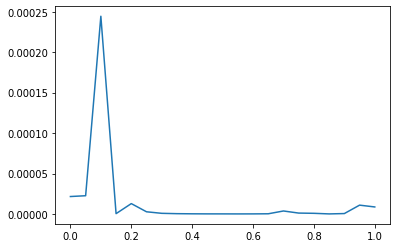

In [17]:
model = Sequential()
model.add(Dense(50, input_dim = Xtrain.shape[1]-1, activation = 'relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer = 'adam')
meansqerrors={}
for i in range(21):
    j = i/20
    ystrain = ybtrain-j*(ybtrain-yctrain)
    ysvalid = ybvalid-j*(ybvalid-ycvalid)
    model.fit(Xtrain.drop(columns=['CensusTract']), ystrain, epochs = 1000, batch_size = 16)
    score = model.evaluate(Xvalid.drop(columns=['CensusTract']), ysvalid)
    meansqerrors[j]=score
    print(j,score)
plt.plot(list(meansqerrors.keys()), list(meansqerrors.values()))

# Fit Model to Best Smoothing

In [18]:
ys = y-.15*(y-yc)
yst = yt-.15*(yt-yct)
model = Sequential()
model.add(Dense(50, input_dim = X.shape[1]-1, activation = 'relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['mean_squared_error','mean_absolute_error'])
model.fit(X.drop(columns=['CensusTract']), ys, epochs = 1000, batch_size = 16)

Epoch 1/1000
9422/9422 [==============================] - 1s 59us/step - loss: 1.1392 - mean_squared_error: 1.1392 - mean_absolute_error: 0.7196
Epoch 2/1000
9422/9422 [==============================] - 0s 47us/step - loss: 0.7572 - mean_squared_error: 0.7572 - mean_absolute_error: 0.5711
Epoch 3/1000
9422/9422 [==============================] - 0s 46us/step - loss: 0.6385 - mean_squared_error: 0.6385 - mean_absolute_error: 0.5220
Epoch 4/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.5623 - mean_squared_error: 0.5623 - mean_absolute_error: 0.4864
Epoch 5/1000
9422/9422 [==============================] - 0s 46us/step - loss: 0.5008 - mean_squared_error: 0.5008 - mean_absolute_error: 0.4590
Epoch 6/1000
9422/9422 [==============================] - 0s 46us/step - loss: 0.4588 - mean_squared_error: 0.4588 - mean_absolute_error: 0.4376
Epoch 7/1000
9422/9422 [==============================] - 0s 46us/step - loss: 0.4160 - mean_squared_error: 0.4160 - mean_absolute

9422/9422 [==============================] - 0s 44us/step - loss: 0.1401 - mean_squared_error: 0.1401 - mean_absolute_error: 0.2297
Epoch 58/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.1473 - mean_squared_error: 0.1473 - mean_absolute_error: 0.2372
Epoch 59/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.1416 - mean_squared_error: 0.1416 - mean_absolute_error: 0.2296
Epoch 60/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.1405 - mean_squared_error: 0.1405 - mean_absolute_error: 0.2292 0s - loss: 0.1399 - mean_squared_error: 0.1399 - mean_absolute_error: 0.22
Epoch 61/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.1407 - mean_squared_error: 0.1407 - mean_absolute_error: 0.2286
Epoch 62/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.1387 - mean_squared_error: 0.1387 - mean_absolute_error: 0.2296
Epoch 63/1000
9422/9422 [==============================] - 0s 4

9422/9422 [==============================] - 0s 44us/step - loss: 0.1075 - mean_squared_error: 0.1075 - mean_absolute_error: 0.2034
Epoch 113/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.1064 - mean_squared_error: 0.1064 - mean_absolute_error: 0.2049
Epoch 114/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.1008 - mean_squared_error: 0.1008 - mean_absolute_error: 0.1973
Epoch 115/1000
9422/9422 [==============================] - 0s 46us/step - loss: 0.1026 - mean_squared_error: 0.1026 - mean_absolute_error: 0.1998
Epoch 116/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.1000 - mean_squared_error: 0.1000 - mean_absolute_error: 0.1968
Epoch 117/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.1057 - mean_squared_error: 0.1057 - mean_absolute_error: 0.2036
Epoch 118/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0980 - mean_squared_error: 0.0980 - mean_absolute_

9422/9422 [==============================] - 0s 44us/step - loss: 0.0842 - mean_squared_error: 0.0842 - mean_absolute_error: 0.1816
Epoch 168/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.0856 - mean_squared_error: 0.0856 - mean_absolute_error: 0.1866
Epoch 169/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.0878 - mean_squared_error: 0.0878 - mean_absolute_error: 0.1883
Epoch 170/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.0845 - mean_squared_error: 0.0845 - mean_absolute_error: 0.1822
Epoch 171/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0867 - mean_squared_error: 0.0867 - mean_absolute_error: 0.1853
Epoch 172/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0819 - mean_squared_error: 0.0819 - mean_absolute_error: 0.1796
Epoch 173/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0829 - mean_squared_error: 0.0829 - mean_absolute_

9422/9422 [==============================] - 0s 45us/step - loss: 0.0804 - mean_squared_error: 0.0804 - mean_absolute_error: 0.1778
Epoch 223/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0800 - mean_squared_error: 0.0800 - mean_absolute_error: 0.1814
Epoch 224/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0758 - mean_squared_error: 0.0758 - mean_absolute_error: 0.1738
Epoch 225/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.0784 - mean_squared_error: 0.0784 - mean_absolute_error: 0.1779
Epoch 226/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0752 - mean_squared_error: 0.0752 - mean_absolute_error: 0.1731
Epoch 227/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.0811 - mean_squared_error: 0.0811 - mean_absolute_error: 0.1777
Epoch 228/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0722 - mean_squared_error: 0.0722 - mean_absolute_

9422/9422 [==============================] - 0s 45us/step - loss: 0.0711 - mean_squared_error: 0.0711 - mean_absolute_error: 0.1710
Epoch 278/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0733 - mean_squared_error: 0.0733 - mean_absolute_error: 0.1753
Epoch 279/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0725 - mean_squared_error: 0.0725 - mean_absolute_error: 0.1729
Epoch 280/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0708 - mean_squared_error: 0.0708 - mean_absolute_error: 0.1723
Epoch 281/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.0669 - mean_squared_error: 0.0669 - mean_absolute_error: 0.1641
Epoch 282/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0722 - mean_squared_error: 0.0722 - mean_absolute_error: 0.1734
Epoch 283/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0708 - mean_squared_error: 0.0708 - mean_absolute_

9422/9422 [==============================] - 0s 45us/step - loss: 0.0692 - mean_squared_error: 0.0692 - mean_absolute_error: 0.1688
Epoch 333/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.0626 - mean_squared_error: 0.0626 - mean_absolute_error: 0.1596
Epoch 334/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.0694 - mean_squared_error: 0.0694 - mean_absolute_error: 0.1693
Epoch 335/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0615 - mean_squared_error: 0.0615 - mean_absolute_error: 0.1572
Epoch 336/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0811 - mean_squared_error: 0.0811 - mean_absolute_error: 0.1763
Epoch 337/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0621 - mean_squared_error: 0.0621 - mean_absolute_error: 0.1580
Epoch 338/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0646 - mean_squared_error: 0.0646 - mean_absolute_

9422/9422 [==============================] - 0s 45us/step - loss: 0.0607 - mean_squared_error: 0.0607 - mean_absolute_error: 0.1561
Epoch 388/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0689 - mean_squared_error: 0.0689 - mean_absolute_error: 0.1622
Epoch 389/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.0579 - mean_squared_error: 0.0579 - mean_absolute_error: 0.1541
Epoch 390/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0595 - mean_squared_error: 0.0595 - mean_absolute_error: 0.1550
Epoch 391/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.0630 - mean_squared_error: 0.0630 - mean_absolute_error: 0.1601
Epoch 392/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0621 - mean_squared_error: 0.0621 - mean_absolute_error: 0.1617
Epoch 393/1000
9422/9422 [==============================] - 0s 46us/step - loss: 0.0628 - mean_squared_error: 0.0628 - mean_absolute_

9422/9422 [==============================] - 0s 45us/step - loss: 0.0600 - mean_squared_error: 0.0600 - mean_absolute_error: 0.1586
Epoch 443/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.0571 - mean_squared_error: 0.0571 - mean_absolute_error: 0.1540
Epoch 444/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0597 - mean_squared_error: 0.0597 - mean_absolute_error: 0.1614
Epoch 445/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.0585 - mean_squared_error: 0.0585 - mean_absolute_error: 0.1553
Epoch 446/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.0557 - mean_squared_error: 0.0557 - mean_absolute_error: 0.1518
Epoch 447/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0607 - mean_squared_error: 0.0607 - mean_absolute_error: 0.1594
Epoch 448/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0563 - mean_squared_error: 0.0563 - mean_absolute_

9422/9422 [==============================] - 0s 46us/step - loss: 0.0520 - mean_squared_error: 0.0520 - mean_absolute_error: 0.1477
Epoch 498/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0560 - mean_squared_error: 0.0560 - mean_absolute_error: 0.1552
Epoch 499/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.0526 - mean_squared_error: 0.0526 - mean_absolute_error: 0.1473
Epoch 500/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0519 - mean_squared_error: 0.0519 - mean_absolute_error: 0.1474
Epoch 501/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0545 - mean_squared_error: 0.0545 - mean_absolute_error: 0.1521
Epoch 502/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.0582 - mean_squared_error: 0.0582 - mean_absolute_error: 0.1564
Epoch 503/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0532 - mean_squared_error: 0.0532 - mean_absolute_

9422/9422 [==============================] - 0s 45us/step - loss: 0.0537 - mean_squared_error: 0.0537 - mean_absolute_error: 0.1515
Epoch 553/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0534 - mean_squared_error: 0.0534 - mean_absolute_error: 0.1487
Epoch 554/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.0529 - mean_squared_error: 0.0529 - mean_absolute_error: 0.1494
Epoch 555/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0546 - mean_squared_error: 0.0546 - mean_absolute_error: 0.1522
Epoch 556/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.0515 - mean_squared_error: 0.0515 - mean_absolute_error: 0.1428
Epoch 557/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0532 - mean_squared_error: 0.0532 - mean_absolute_error: 0.1499
Epoch 558/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0587 - mean_squared_error: 0.0587 - mean_absolute_

9422/9422 [==============================] - 0s 44us/step - loss: 0.0504 - mean_squared_error: 0.0504 - mean_absolute_error: 0.1455
Epoch 608/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0504 - mean_squared_error: 0.0504 - mean_absolute_error: 0.1481
Epoch 609/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0537 - mean_squared_error: 0.0537 - mean_absolute_error: 0.1491
Epoch 610/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.0476 - mean_squared_error: 0.0476 - mean_absolute_error: 0.1406
Epoch 611/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0494 - mean_squared_error: 0.0494 - mean_absolute_error: 0.1454
Epoch 612/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0482 - mean_squared_error: 0.0482 - mean_absolute_error: 0.1421
Epoch 613/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0581 - mean_squared_error: 0.0581 - mean_absolute_

9422/9422 [==============================] - 0s 45us/step - loss: 0.0451 - mean_squared_error: 0.0451 - mean_absolute_error: 0.1363
Epoch 663/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0476 - mean_squared_error: 0.0476 - mean_absolute_error: 0.1421
Epoch 664/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0503 - mean_squared_error: 0.0503 - mean_absolute_error: 0.1475
Epoch 665/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.0469 - mean_squared_error: 0.0469 - mean_absolute_error: 0.1415
Epoch 666/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0553 - mean_squared_error: 0.0553 - mean_absolute_error: 0.1500
Epoch 667/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.0481 - mean_squared_error: 0.0481 - mean_absolute_error: 0.1423
Epoch 668/1000
9422/9422 [==============================] - 0s 46us/step - loss: 0.0467 - mean_squared_error: 0.0467 - mean_absolute_

9422/9422 [==============================] - 0s 45us/step - loss: 0.0460 - mean_squared_error: 0.0460 - mean_absolute_error: 0.1413
Epoch 718/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0458 - mean_squared_error: 0.0458 - mean_absolute_error: 0.1397
Epoch 719/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.0574 - mean_squared_error: 0.0574 - mean_absolute_error: 0.1500
Epoch 720/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0463 - mean_squared_error: 0.0463 - mean_absolute_error: 0.1403
Epoch 721/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0504 - mean_squared_error: 0.0504 - mean_absolute_error: 0.1423
Epoch 722/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0449 - mean_squared_error: 0.0449 - mean_absolute_error: 0.1373
Epoch 723/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0438 - mean_squared_error: 0.0438 - mean_absolute_

9422/9422 [==============================] - 0s 45us/step - loss: 0.0433 - mean_squared_error: 0.0433 - mean_absolute_error: 0.1365
Epoch 773/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0476 - mean_squared_error: 0.0476 - mean_absolute_error: 0.1371
Epoch 774/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0497 - mean_squared_error: 0.0497 - mean_absolute_error: 0.1474
Epoch 775/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.0430 - mean_squared_error: 0.0430 - mean_absolute_error: 0.1351
Epoch 776/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0425 - mean_squared_error: 0.0425 - mean_absolute_error: 0.1346
Epoch 777/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.0455 - mean_squared_error: 0.0455 - mean_absolute_error: 0.1401
Epoch 778/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0438 - mean_squared_error: 0.0438 - mean_absolute_

9422/9422 [==============================] - 0s 44us/step - loss: 0.0426 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1365
Epoch 828/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0412 - mean_squared_error: 0.0412 - mean_absolute_error: 0.1315
Epoch 829/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0426 - mean_squared_error: 0.0426 - mean_absolute_error: 0.1365
Epoch 830/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0452 - mean_squared_error: 0.0452 - mean_absolute_error: 0.1392
Epoch 831/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0411 - mean_squared_error: 0.0411 - mean_absolute_error: 0.1319
Epoch 832/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.0448 - mean_squared_error: 0.0448 - mean_absolute_error: 0.1396
Epoch 833/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0429 - mean_squared_error: 0.0429 - mean_absolute_

9422/9422 [==============================] - 0s 45us/step - loss: 0.0415 - mean_squared_error: 0.0415 - mean_absolute_error: 0.1329
Epoch 883/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0416 - mean_squared_error: 0.0416 - mean_absolute_error: 0.1345
Epoch 884/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0464 - mean_squared_error: 0.0464 - mean_absolute_error: 0.1437
Epoch 885/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.0450 - mean_squared_error: 0.0450 - mean_absolute_error: 0.1339
Epoch 886/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0375 - mean_squared_error: 0.0375 - mean_absolute_error: 0.1249
Epoch 887/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.0403 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1315
Epoch 888/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.0418 - mean_squared_error: 0.0418 - mean_absolute_

9422/9422 [==============================] - 0s 45us/step - loss: 0.0491 - mean_squared_error: 0.0491 - mean_absolute_error: 0.1480
Epoch 938/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0371 - mean_squared_error: 0.0371 - mean_absolute_error: 0.1246
Epoch 939/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.0372 - mean_squared_error: 0.0372 - mean_absolute_error: 0.1252
Epoch 940/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0437 - mean_squared_error: 0.0437 - mean_absolute_error: 0.1377
Epoch 941/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0396 - mean_squared_error: 0.0396 - mean_absolute_error: 0.1320
Epoch 942/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.0422 - mean_squared_error: 0.0422 - mean_absolute_error: 0.1364
Epoch 943/1000
9422/9422 [==============================] - 0s 47us/step - loss: 0.0432 - mean_squared_error: 0.0432 - mean_absolute_

9422/9422 [==============================] - 0s 45us/step - loss: 0.0476 - mean_squared_error: 0.0476 - mean_absolute_error: 0.1406
Epoch 993/1000
9422/9422 [==============================] - 0s 46us/step - loss: 0.0443 - mean_squared_error: 0.0443 - mean_absolute_error: 0.1374
Epoch 994/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0391 - mean_squared_error: 0.0391 - mean_absolute_error: 0.1310
Epoch 995/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0377 - mean_squared_error: 0.0377 - mean_absolute_error: 0.1277
Epoch 996/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.0395 - mean_squared_error: 0.0395 - mean_absolute_error: 0.1316
Epoch 997/1000
9422/9422 [==============================] - 0s 45us/step - loss: 0.0407 - mean_squared_error: 0.0407 - mean_absolute_error: 0.1320
Epoch 998/1000
9422/9422 [==============================] - 0s 44us/step - loss: 0.0428 - mean_squared_error: 0.0428 - mean_absolute_

# Predict Bias of Smoothed Test Sets

In [19]:
_, MSE, MAE = model.evaluate(Xt.drop(columns=['CensusTract']), yst)
print('MSE: ' + str(MSE) + ', MAE: '+ str(MAE))

2355/2355 [==============================] - 0s 21us/step
MSE: 0.10568083275402175, MAE: 0.17933126575374805


# Create Dataset to Visualize Smoothing

In [20]:
block_data = pd.read_csv("census_block_loc.csv")
tracts = block_data["BlockCode"]
tracts = [int(str(tract)[:-4]) for tract in tracts]
block_data["tracts"]=tracts
X['y']=y
X['ys']=ys
X['yc']=yc
X = X[['CensusTract','y','yc','ys']]
X = pd.merge(left=X, right=block_data, left_on="CensusTract", right_on="tracts")
X = X.drop(columns=["BlockCode","County","State","CensusTract","tracts"])
X

,y,yc,ys,Latitude,Longitude
0,2.013588,1.534278,1.941692,40.841809,-73.874774
1,2.013588,1.534278,1.941692,40.844070,-73.874774
2,2.013588,1.534278,1.941692,40.846332,-73.877940
3,2.013588,1.534278,1.941692,40.846332,-73.874774
4,2.013588,1.534278,1.941692,40.846332,-73.871608
5,2.013588,1.534278,1.941692,40.848593,-73.881106
6,2.013588,1.534278,1.941692,40.848593,-73.877940
7,2.013588,1.534278,1.941692,40.848593,-73.874774
8,2.013588,1.534278,1.941692,40.848593,-73.871608
9,2.013588,1.534278,1.941692,40.850854,-73.881106


In [56]:
X.to_csv('smoothdata.csv')

# Visualize Smoothing